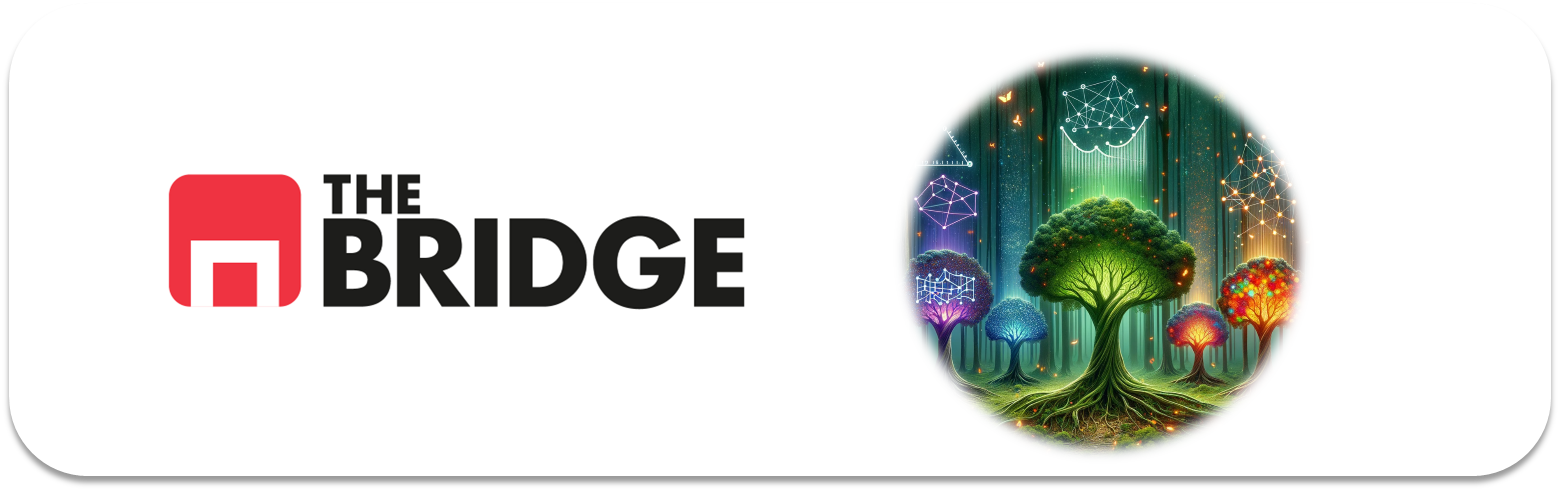

# PRÁCTICA OBLIGATORIA
## **Árboles de Decisión y Ajuste de Hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo.
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso.

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [2]:
from scipy import stats

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_bank = pd.read_csv("./data/bank-full.csv", sep=";")
df_bank.head()

age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no

### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset **Bank Marketing** de la *UCI Machine Learning Repository*). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test


> **AYUDA**: La dirección del banco nos proporciona estas notas (en inglés):
>
> **BANK CLIENT DATA:**
> 1. **age** (numeric).
> 2. **job**: type of job (categorical: "admin.", "unknown", "unemployed", "management", "housemaid", "entrepreneur", "student", "blue-collar", "self-employed", "retired", "technician", "services").
> 3. **marital**: marital status (categorical: "married", "divorced", "single"; note: "divorced" means divorced or widowed).
> 4. **education**: (categorical: "unknown", "secondary", "primary", "tertiary").
> 5. **default**: has credit in default? (binary: "yes", "no").
> 6. **balance**: average yearly balance, in euros (numeric).
> 7. **housing**: has housing loan? (binary: "yes", "no").
> 8. **loan**: has personal loan? (binary: "yes", "no").
> 
> **RELATED WITH THE LAST CONTACT OF THE CURRENT CAMPAIGN:**
> 
> 9. **contact**: contact communication type (categorical: "unknown", "telephone", "cellular").
> 10. **day**: last contact day of the month (numeric).
> 11. **month**: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec").
> 12. **duration**: last contact duration, in seconds (numeric).
> 
> **OTHER ATTRIBUTES:**
> 
> 13. **campaign**: number of contacts performed during this campaign and for this client (numeric, includes last contact).
> 14. **pdays**: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted).
> 15. **previous**: number of contacts performed before this campaign and for this client (numeric).
> 16. **poutcome**: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success").

## Análisis
### Reconocimiento

Revisamos tipos de datos, registros totales y columnas del dataset.

In [4]:
print(f"El dataset cuenta con {df_bank.shape[0]} registros.") 
print(f"El dataset cuenta con {df_bank.shape[1]} columnas.") 
print("="*40)
df_bank.info()

El dataset cuenta con 45211 registros.
El dataset cuenta con 17 columnas.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Revisamos los duplicados

In [5]:
is_duplicated = df_bank.duplicated()
df_bank[is_duplicated]

Empty DataFrame
Columns: [age, job, marital, education, default, balance, housing, loan, contact, day, month, duration, campaign, pdays, previous, poutcome, y]
Index: []

Valores nulos, cardinalidad e unicidad

In [6]:
def get_quality(dataframe: pd.DataFrame):
	if dataframe is None:
		raise ValueError("Dataframe sin especificar.")

	if not isinstance(dataframe, pd.DataFrame):
		raise ValueError("El dataframe debe ser pd.DataFrame")

	records = dataframe.shape[0]

	unique = dataframe.nunique().rename("Cardinality")
	cardinality = (unique/records).rename("Uniqueness")
	null = (dataframe.isna().sum()).rename("Null")

	data = pd.DataFrame(data=[unique, cardinality, null])
	return data.T

get_quality(df_bank)

Cardinality  Uniqueness  Null
age               77.0    0.001703   0.0
job               12.0    0.000265   0.0
marital            3.0    0.000066   0.0
education          4.0    0.000088   0.0
default            2.0    0.000044   0.0
balance         7168.0    0.158545   0.0
housing            2.0    0.000044   0.0
loan               2.0    0.000044   0.0
contact            3.0    0.000066   0.0
day               31.0    0.000686   0.0
month             12.0    0.000265   0.0
duration        1573.0    0.034792   0.0
campaign          48.0    0.001062   0.0
pdays            559.0    0.012364   0.0
previous          41.0    0.000907   0.0
poutcome           4.0    0.000088   0.0
y                  2.0    0.000044   0.0

In [92]:
def filter_outliers(serie: pd.Series,
					whisker: float | None=1.75,
					below_zero=False):
	q25 = serie.quantile(.25)
	q75 = serie.quantile(.75)
	iqr = q75 - q25

	minimum = q25 - whisker * iqr
	maximum = q75 + whisker * iqr

	if minimum < 0:
		minimum = minimum if below_zero else 0

	below_minimum = serie > minimum
	above_maximum = serie < maximum
	mask = below_minimum & above_maximum

	filtered = serie[mask]
	return filtered

In [57]:
from matplotlib import ticker



def plot_category(serie: pd.Series):
	fig, axs = plt.subplots(nrows=1,
							ncols=2,
							figsize=(10, 4),
							layout="constrained")
	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}

	fig.suptitle(f"{serie.name}".upper(),
				 color="#C5BFFD",
				 fontproperties=font_config,
				 y=1.10)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[0].set_title("Cantidad absoluta",
					color="#C5BFFD",
					fontdict=font_config)


	data = serie.value_counts()
	axs[0].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#60A5FA",
			   zorder=2)

	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[0].tick_params(axis="y", width=0)
	axs[0].set_xticks(ticks=data.index)
	#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

	axs[0].set_ylabel("Cantidad",
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[0].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)
	axs[0].spines[["left", "top", "right"]].set_visible(False)
	axs[0].spines["bottom"].set_linewidth(1)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[1].set_title("Cantidad relativa",
					 color="#C5BFFD",
					 fontdict=font_config)


	data = serie.value_counts(normalize=True)
	axs[1].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#FFBD54",
			   zorder=2)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[1].set_xticks(ticks=data.index)
	#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

	axs[1].set_ylabel("Cant. según total", 
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[1].tick_params(axis="y", width=0)
	axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

	axs[1].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)

	axs[1].spines[["left", "top", "right"]].set_visible(False)
	axs[1].spines["bottom"].set_linewidth(1)

	fig.get_layout_engine().set(wspace=0.15)
	plt.show()

#### `MARITAL`

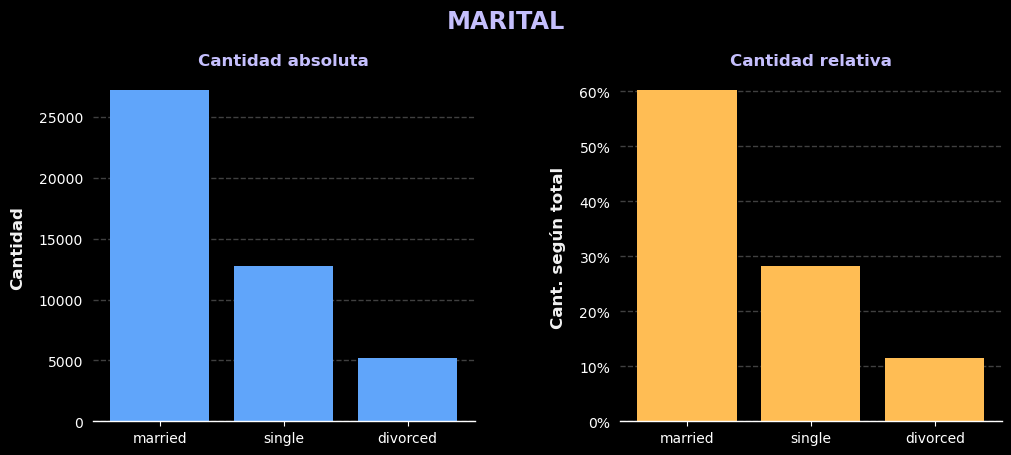

In [11]:
plot_category(df_bank["marital"])

#### `LOAN`

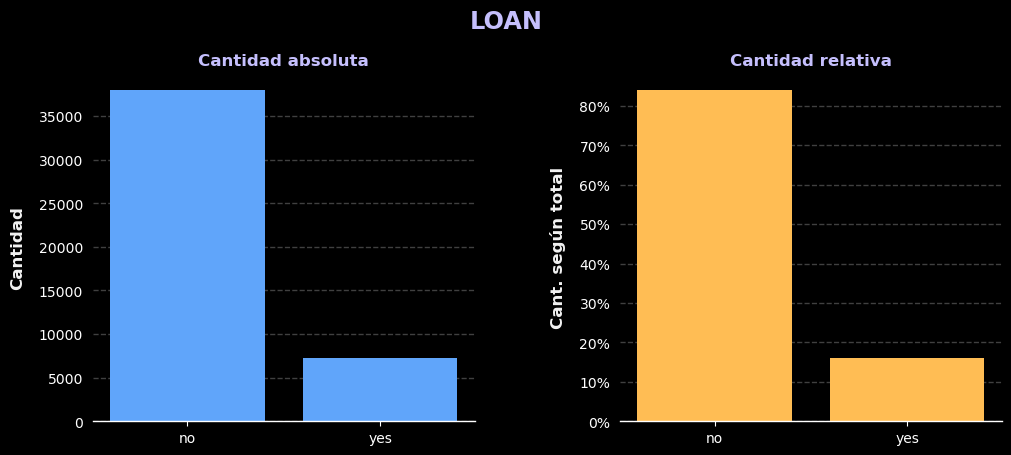

In [12]:
plot_category(df_bank["loan"])

#### `JOB`

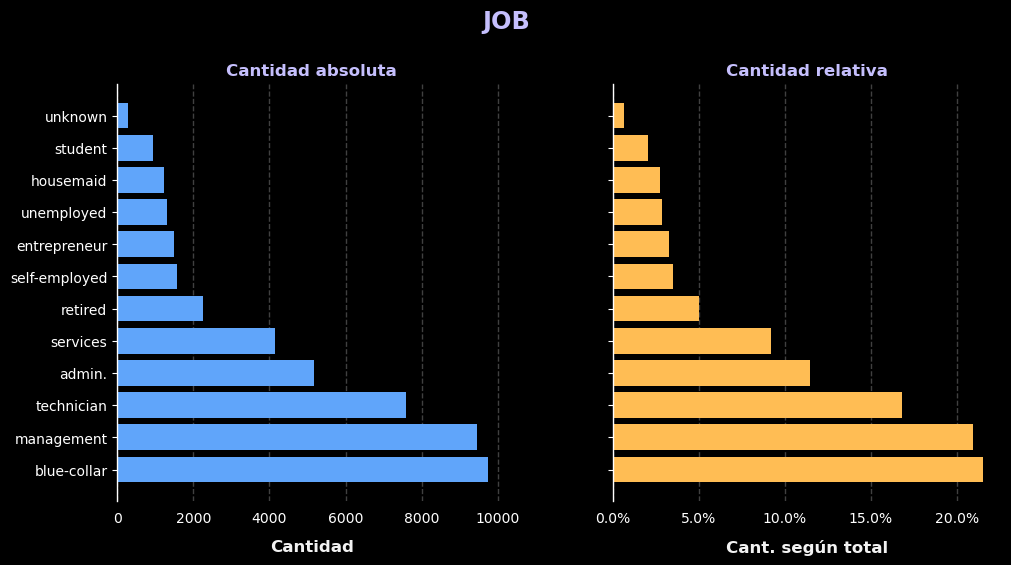

In [13]:
serie = df_bank["job"]


fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### `EDUCATION`

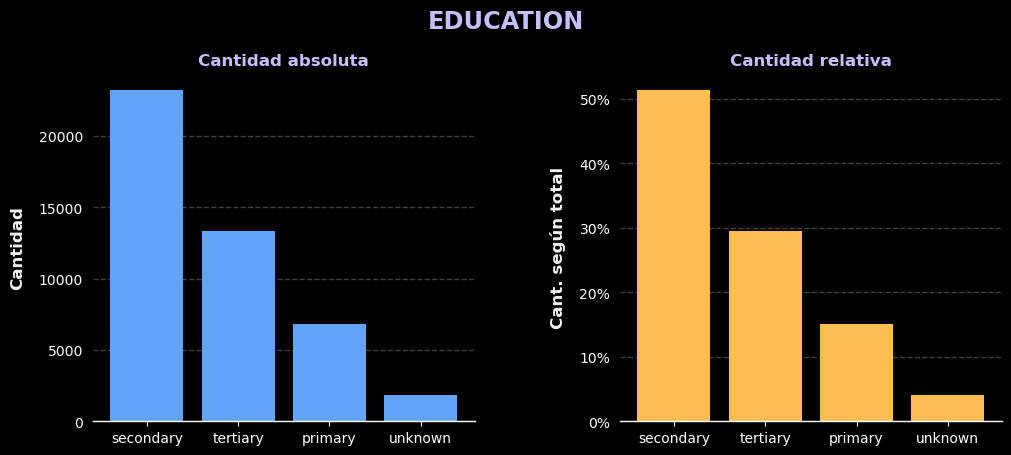

In [14]:
plot_category(df_bank["education"])

#### `DEFAULT`

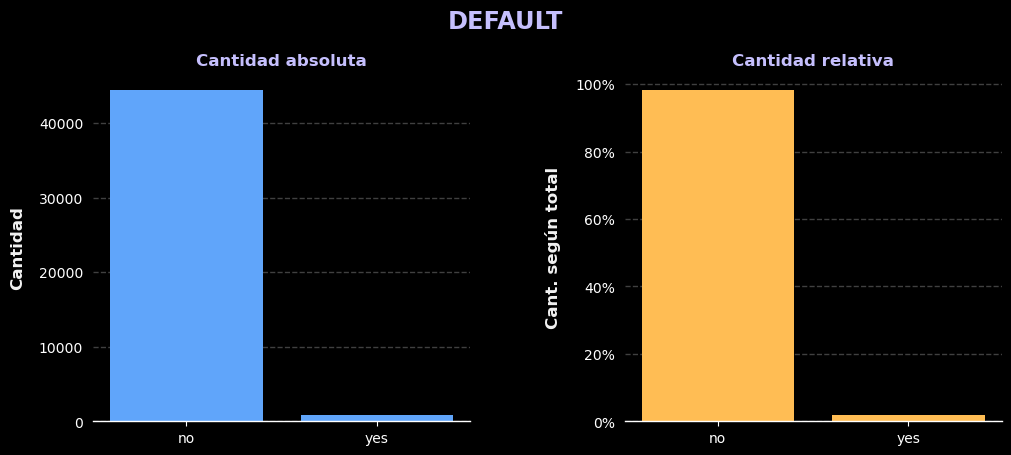

In [15]:
plot_category(df_bank["default"])

#### `HOUSING`

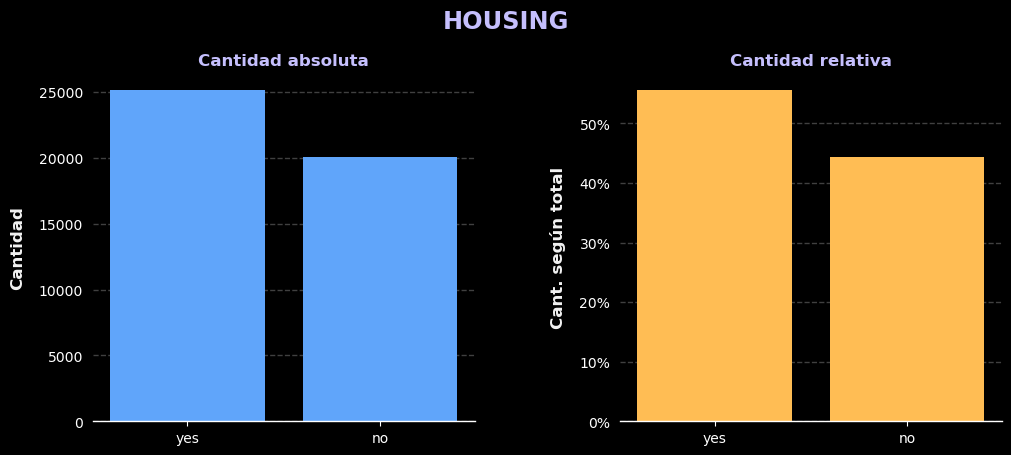

In [16]:
plot_category(df_bank["housing"])

#### `CONTACT`

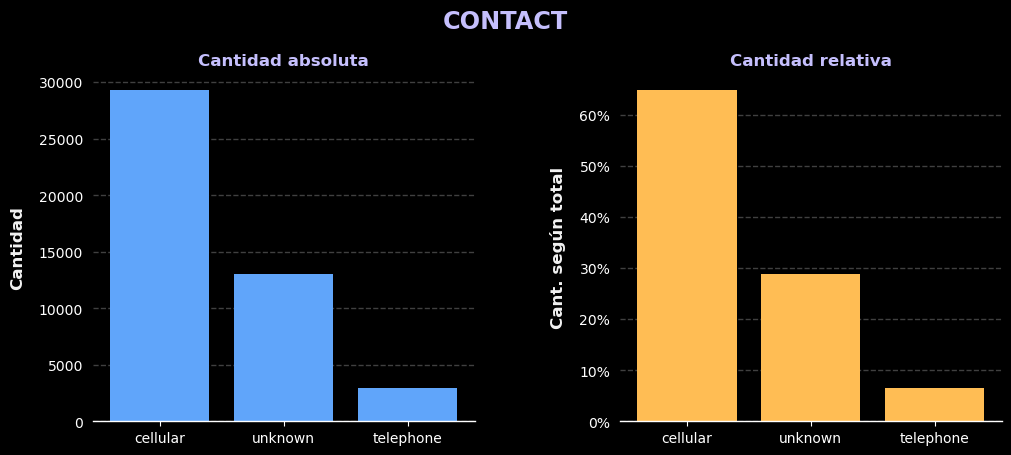

In [17]:
plot_category(df_bank["contact"])

#### `DAY`

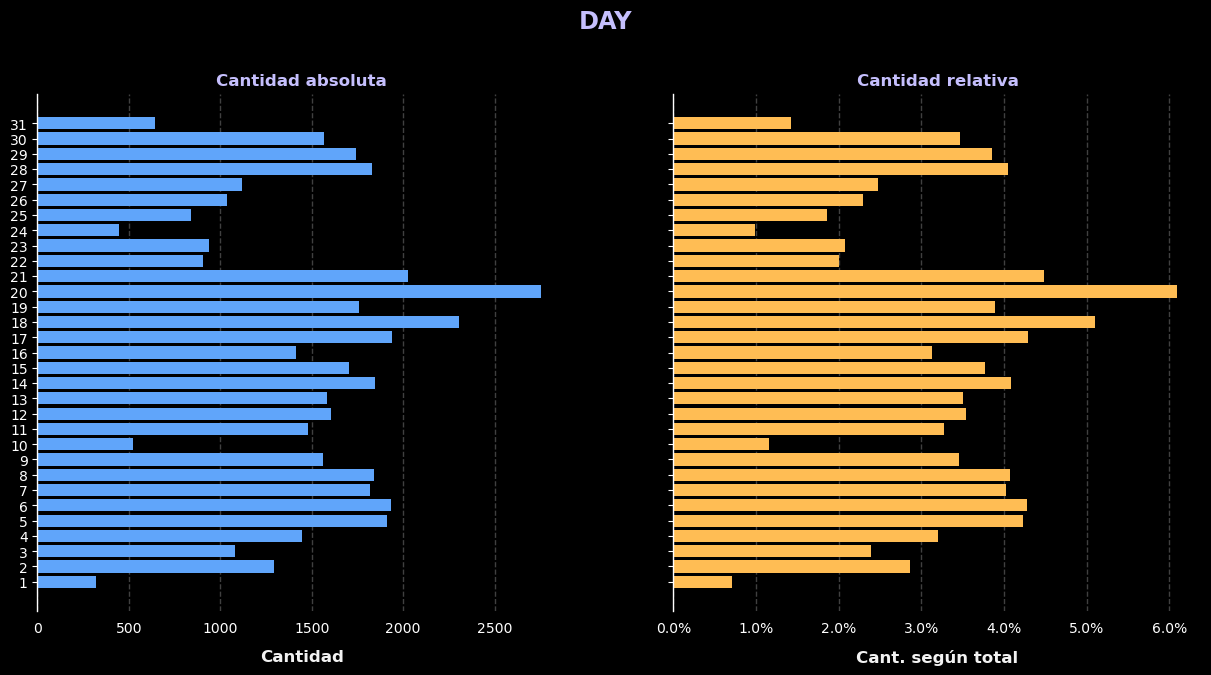

In [18]:
serie = df_bank["day"]


fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(12, 6),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### `MONTH`

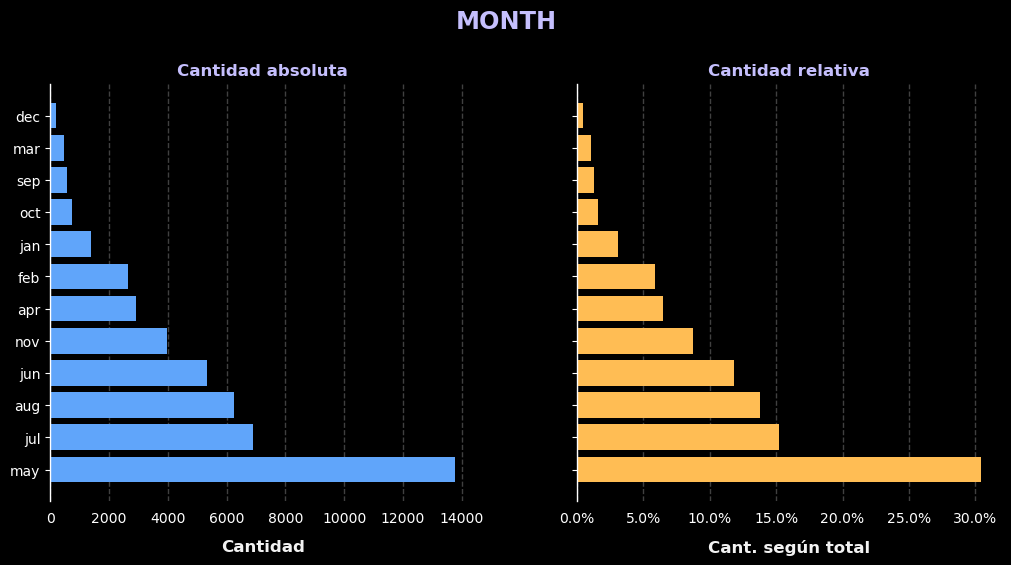

In [19]:
serie = df_bank["month"]


fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### `CAMPAIGN`

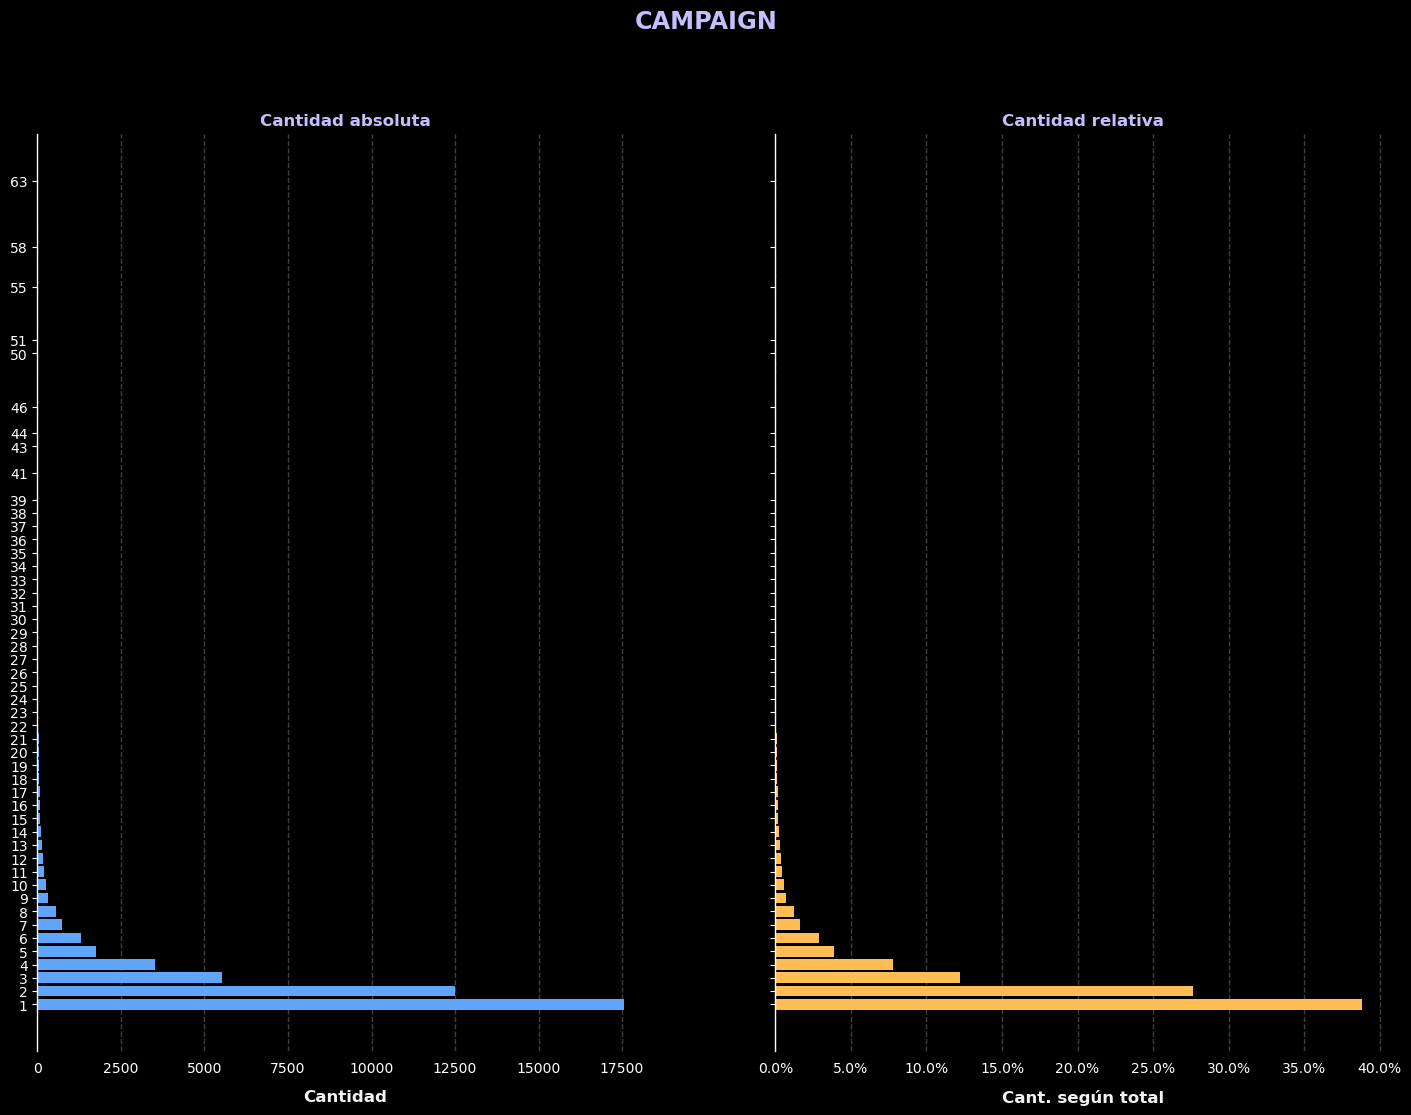

In [20]:
serie = df_bank["campaign"]


fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(14, 10),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### `PREVIOUS`

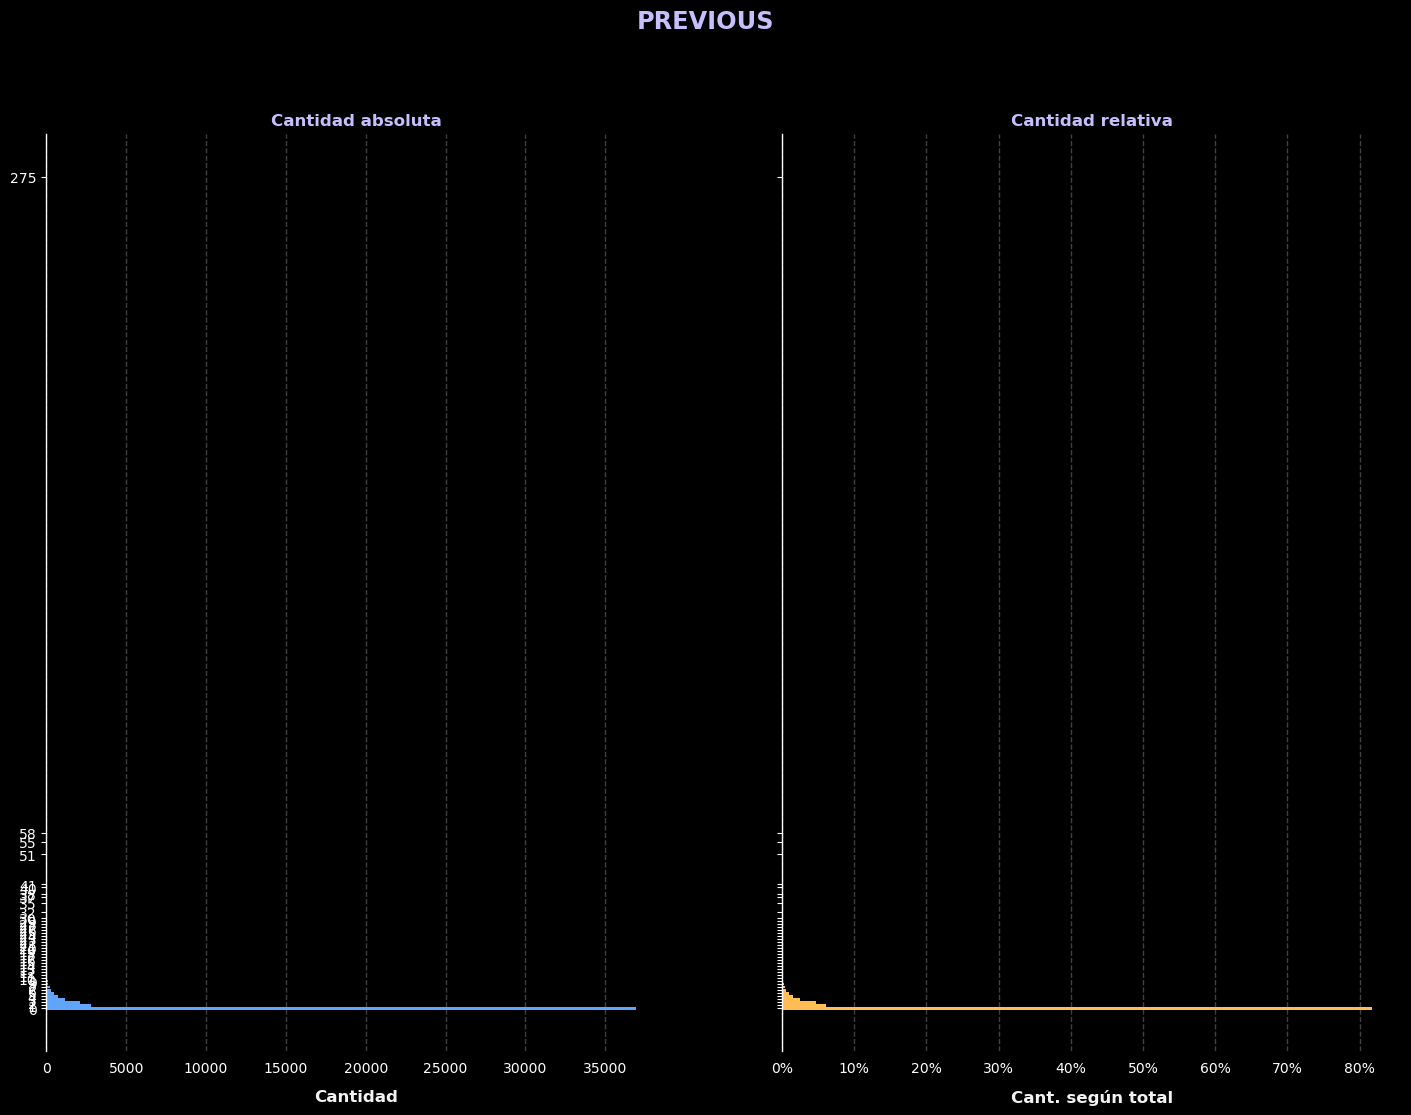

In [21]:
serie = df_bank["previous"]


fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(14, 10),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total", 
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### `POUTCOME`

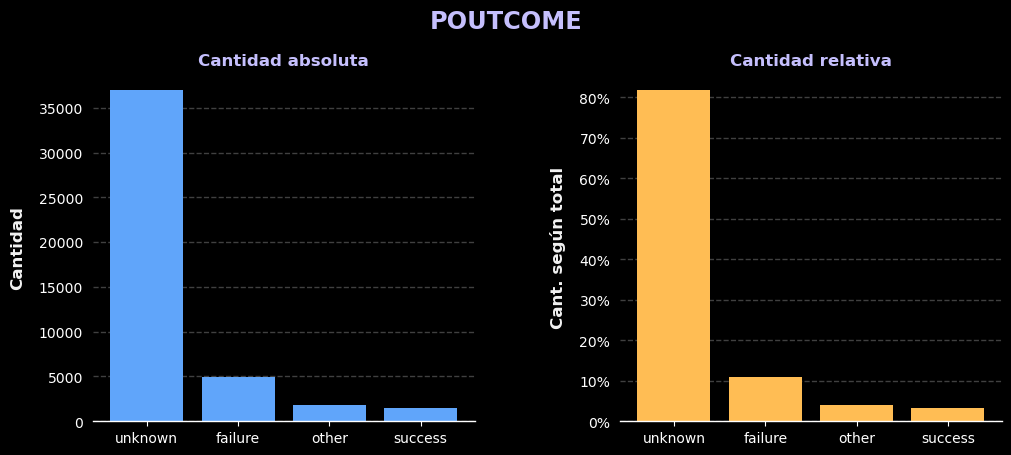

In [22]:
plot_category(df_bank["poutcome"])

#### `Y`

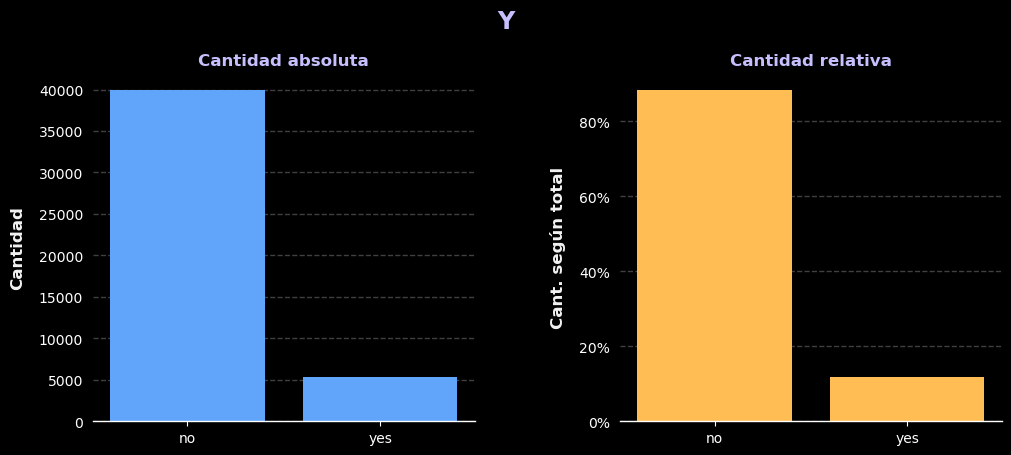

In [23]:
plot_category(df_bank["y"])

Nuestro target se encuentra desbalanceado

#### `BALANCE`

In [81]:
df_bank["balance"].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

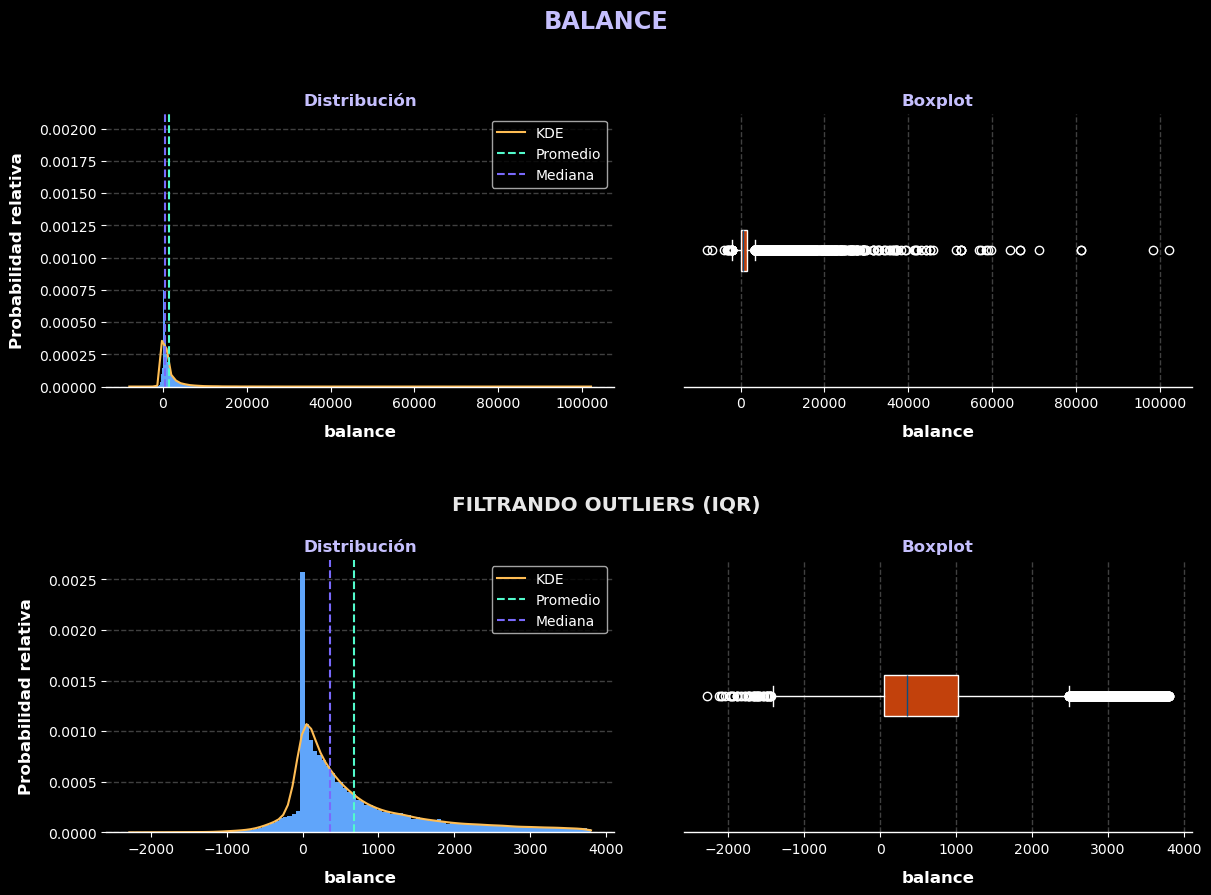

In [120]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle("BALANCE",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

data = df_bank["balance"]
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[0][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("balance", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("balance", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(df_bank["balance"], below_zero=True)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("balance", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("balance", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

#### `DURATION`

In [26]:
df_bank["duration"].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

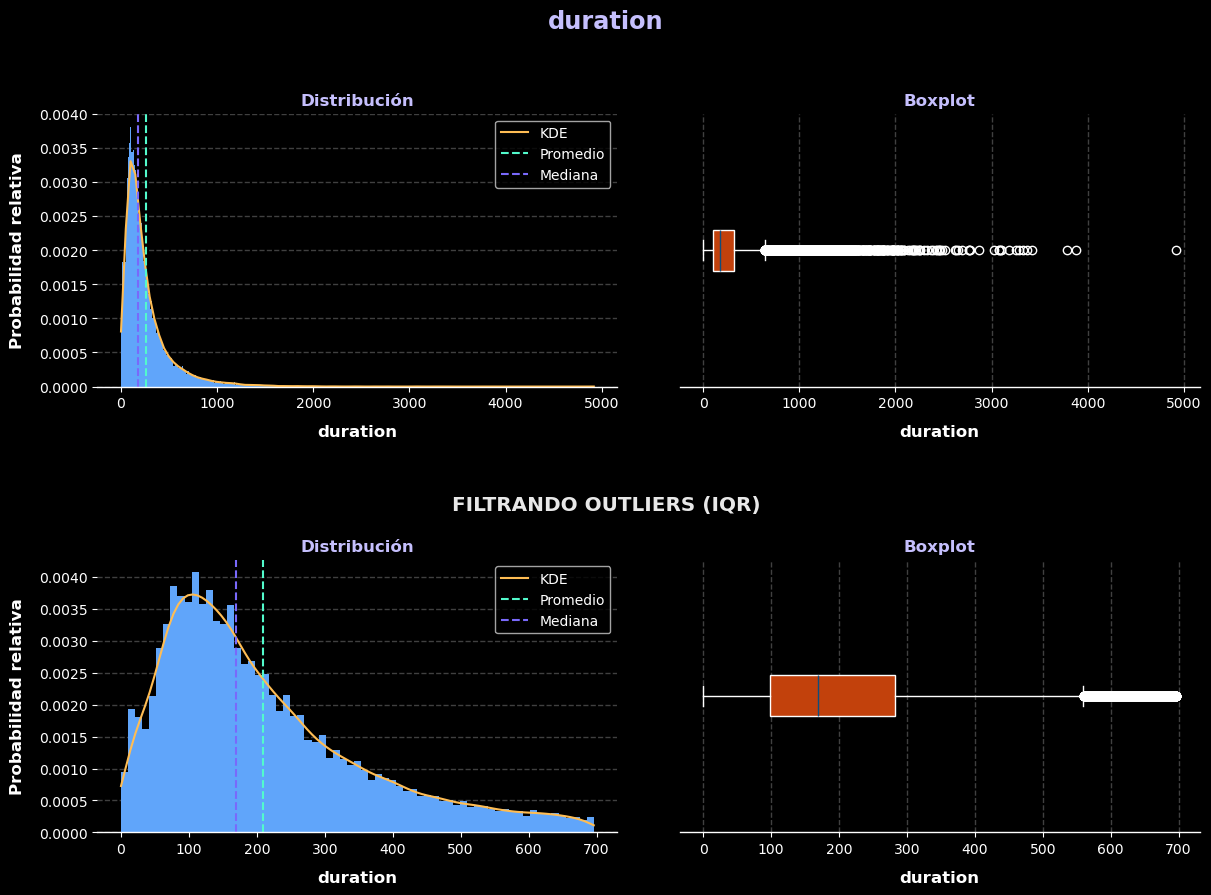

In [121]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle("duration",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

data = df_bank["duration"]
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[0][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("duration", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("duration", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(df_bank["duration"], below_zero=True)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("duration", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("duration", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

#### `PDAYS`

In [28]:
df_bank["pdays"].describe()

count    45211.000000
mean        40.197828
std        100.128746
min         -1.000000
25%         -1.000000
50%         -1.000000
75%         -1.000000
max        871.000000
Name: pdays, dtype: float64

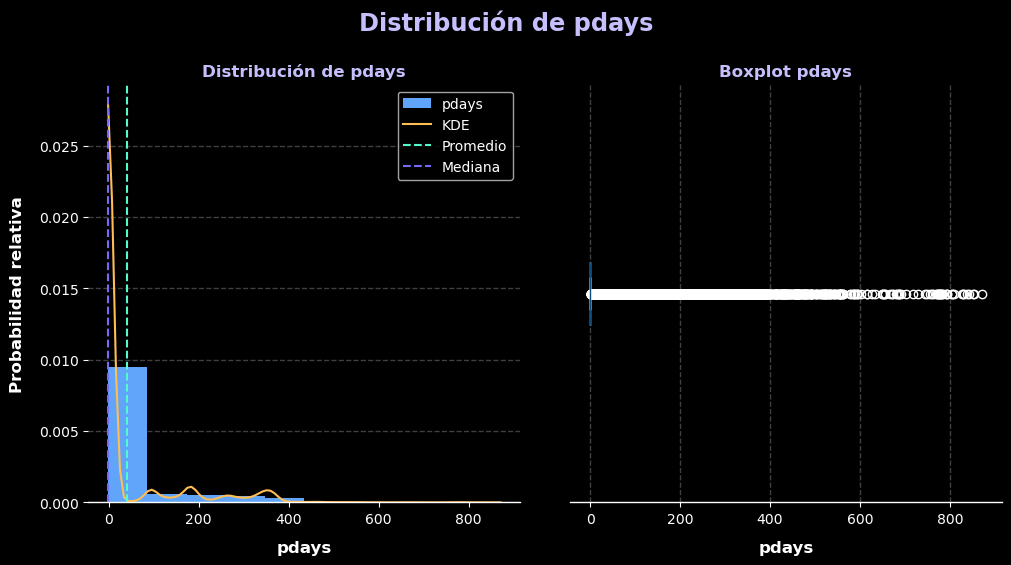

In [190]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle("Distribución de pdays",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Distribución de pdays",
				 color="#C5BFFD",
				 fontdict=font_config)

#bins = np.histogram_bin_edges(df_bank["pdays"], bins="fd")
axs[0].hist(x="pdays",
			data=df_bank,
#			bins=bins,
			density=True,
			color="#60A5FA",
			zorder=2)

x = np.linspace(df_bank["pdays"].min(), df_bank["pdays"].max(), 100)
kde = stats.gaussian_kde(df_bank["pdays"])
axs[0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0].axvline(df_bank["pdays"].mean(),
			   linestyle="dashed",
			   color="#52FACC",
			   label="Promedio")
axs[0].axvline(df_bank["pdays"].median(),
			   linestyle="dashed",
			   color="#7969FB",
			   label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].set_xlabel("pdays", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0].grid(axis="y",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["left", "top", "right"]].set_visible(False)
axs[0].spines["bottom"].set_linewidth(1)
axs[0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot pdays",
				 color="#C5BFFD",
				 fontdict=font_config)

axs[1].boxplot(x="pdays",
			   data=df_bank,
			   boxprops={ "facecolor" : "#C2410C" },
			   medianprops={ "color" : "#0F4D7D" },
			   orientation="horizontal",
			   patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks([])
axs[1].set_xlabel("pdays", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("")
axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["left", "top", "right"]].set_visible(False)
axs[1].spines["bottom"].set_linewidth(1)

fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

#### `AGE`

In [31]:
df_bank["age"].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

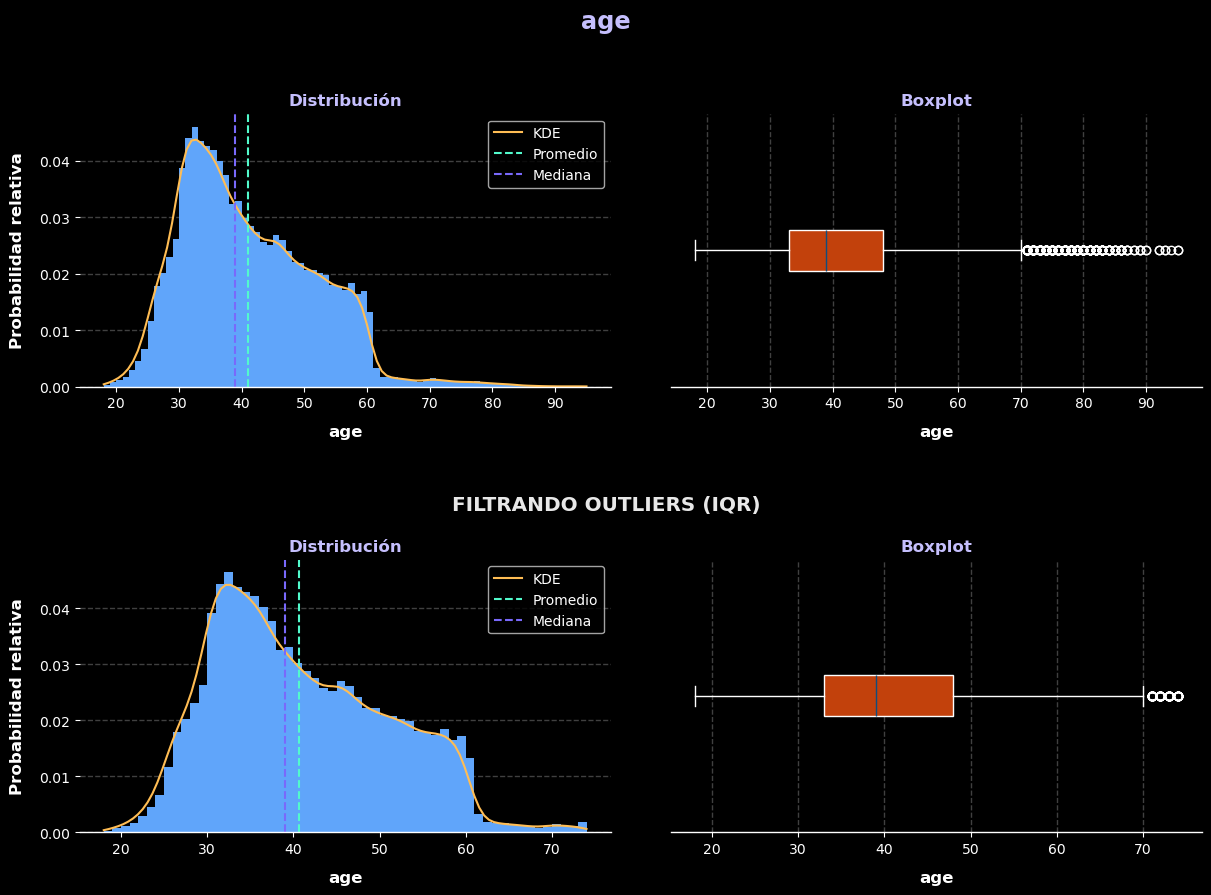

In [135]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle("age",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

data = df_bank["age"]
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[0][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("age", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("age", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(df_bank["age"], below_zero=True)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("age", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("age", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

### Conclusión

Luego de analizar las variables podemos notar que se han imputado valores nulos en varias columnas categóricas como `unknown`. La variable que se ve más afectada es `poutcome` con más del 80% de valores con dicha categoría.

En las variables numéricas encontramos mucha dispersión: por ejemplo, la columna `balance` tiene mucha varianza en los datos, llegando a tener el máximo en 102.127€, mientras que el tercer cuartil se sitúa en 1.428€

`balance.describe()`:

```python
count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
```

## Train-Test split

Hacemos un `train_test_split` realizando el estratificado de la variable `y`.

In [474]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df_bank,
									 test_size=.2,
									 stratify=df_bank["y"],
									 random_state=99)

### Mini-EDA

In [ ]:
import math


def plot_distribution(
	columns: str | list[str],
	dataframe: pd.DataFrame,
	target: str | None=None
) -> None:
	if columns is None:
		raise ValueError("Columna del dataset sin especificar")

	if dataframe is None:
		raise ValueError("Dataframe sin especificar")

	if isinstance(columns, str):
		columns = [columns]

	missing = set(columns) - set(dataframe.columns)
	if missing:
		raise ValueError("Columnas inexistentes en el DataFrame:", missing)

	if isinstance(target, str):
		if target not in dataframe.columns:
			raise ValueError(f"{target} no existe en el DataFrame.")


	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}

	ncols = min(3, len(columns))
	nrows = math.ceil(len(columns) / ncols)

	fig, axs = plt.subplots(ncols=ncols,
							nrows=nrows,
							figsize=(14, 8),
							layout="constrained")
	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}
	fig.suptitle("Análisis de distribución".upper(),
				 color="#C5BFFD",
				 fontproperties=font_config,
				 y=1.10)

	axs = np.atleast_2d(axs)
	index = 0


	for rows in range(nrows):
		for cols in range(ncols):
			font_config = {
				"family": "sans-serif",
				"size": "large",
				"weight": "heavy"
			}

			if index >= len(columns):
				axs[rows][cols].set_visible(False)
				continue

			column = columns[index] if isinstance(columns, list) else columns
			data = dataframe[column]

			axs[rows][cols].set_title(column.upper(),
									  color="#F2F2F2",
									  fontdict=font_config)
			if target:
				cmap = plt.get_cmap("Paired", lut=10)
				groups = dataframe.groupby(by=[target])
				for i, (key, group) in enumerate(groups):
					data = group[column]

					bins = np.histogram_bin_edges(data, bins="fd")
					axs[rows][cols].hist(x=data,
										 bins=bins,
										 density=True,
										 alpha=.8,
										 color=cmap(i),
										 histtype="bar",
										 label=key,
										 zorder=2)
					x = np.linspace(data.min(), data.max(), 100)
					kde = stats.gaussian_kde(data)
					axs[rows][cols].plot(x, kde(x), color="#FFBD54")
			else:
				bins = np.histogram_bin_edges(data, bins="fd")
				axs[rows][cols].hist(x=data,
									 bins=bins,
									 density=True,
									 histtype="bar",
									 alpha=.8,
									 color="#60A5FA",
									 label=column,
									 zorder=2)
				x = np.linspace(data.min(), data.max(), 100)
				kde = stats.gaussian_kde(data)
				axs[rows][cols].plot(x, kde(x), color="#FFBD54")


			font_config = {
				"family": "sans-serif",
				"size": "large",
				"weight": "bold"
			}
			axs[rows][cols].set_ylabel("Probabilidad relativa",
									   labelpad=10,
									   fontdict=font_config)
			axs[rows][cols].grid(axis="y",
								 alpha=1,
								 color="#404040",
								 linestyle="dashed",
								 linewidth=1)
			axs[rows][cols].spines[["left", "top", "right"]].set_visible(False)
			axs[rows][cols].spines["bottom"].set_linewidth(2)

			axs[rows][cols].legend(title=target)

			index += 1

	fig.get_layout_engine().set(hspace=0.1, wspace=0.2)

	plt.show()

In [241]:
def target_groupby_category(target, category, dataframe, relative=False):
	data = dataframe.groupby(by=[target, category]).size().unstack().fillna(0)

	if relative:
		return data.div(data.sum(axis=1), axis=0).round(3)

	return data

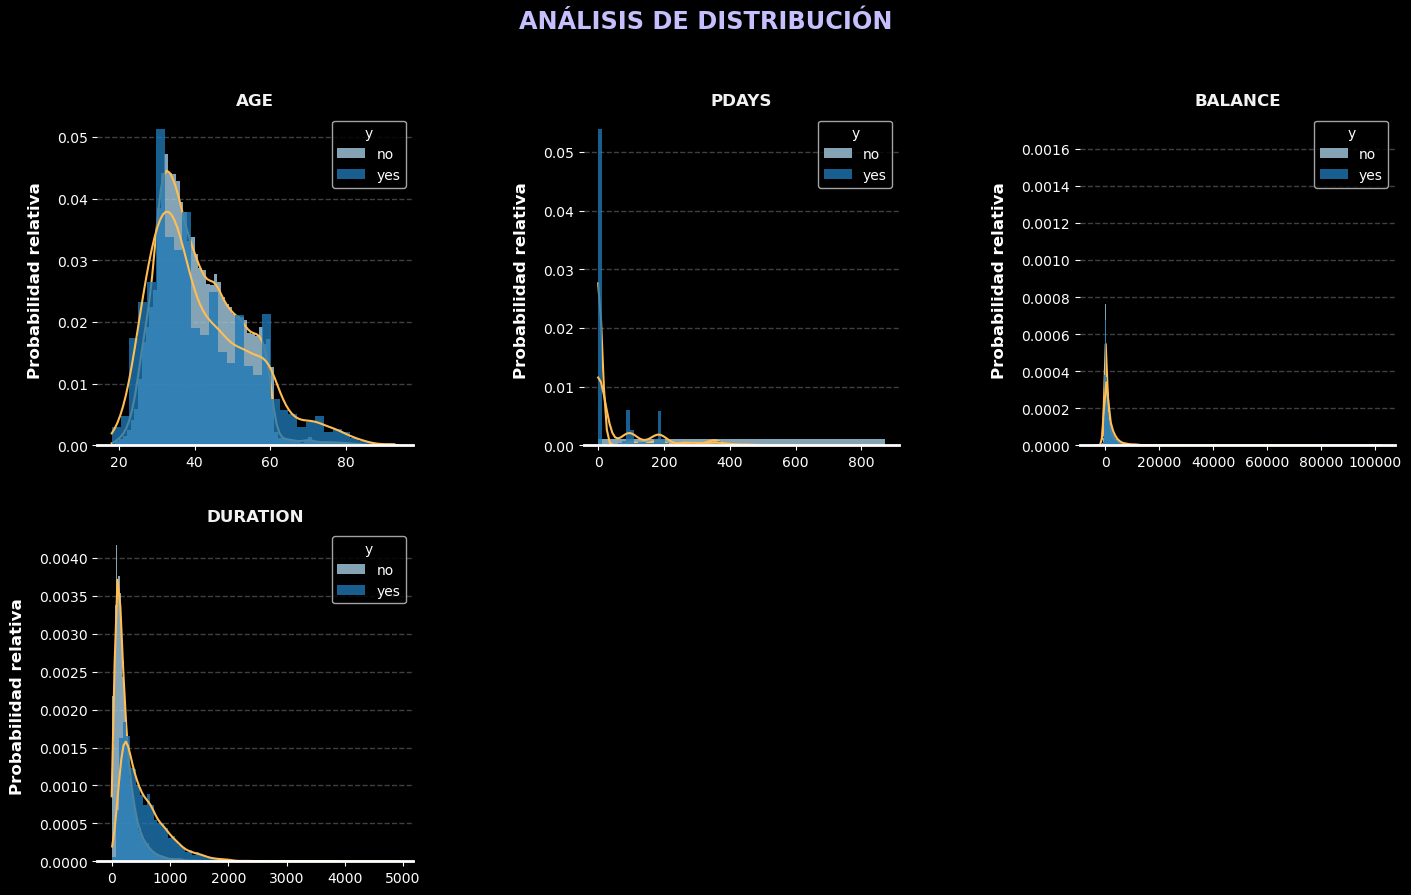

In [240]:
plot_distribution(["age", "pdays", "balance", "duration"], df_train, target="y")

#### Marital vs TARGET

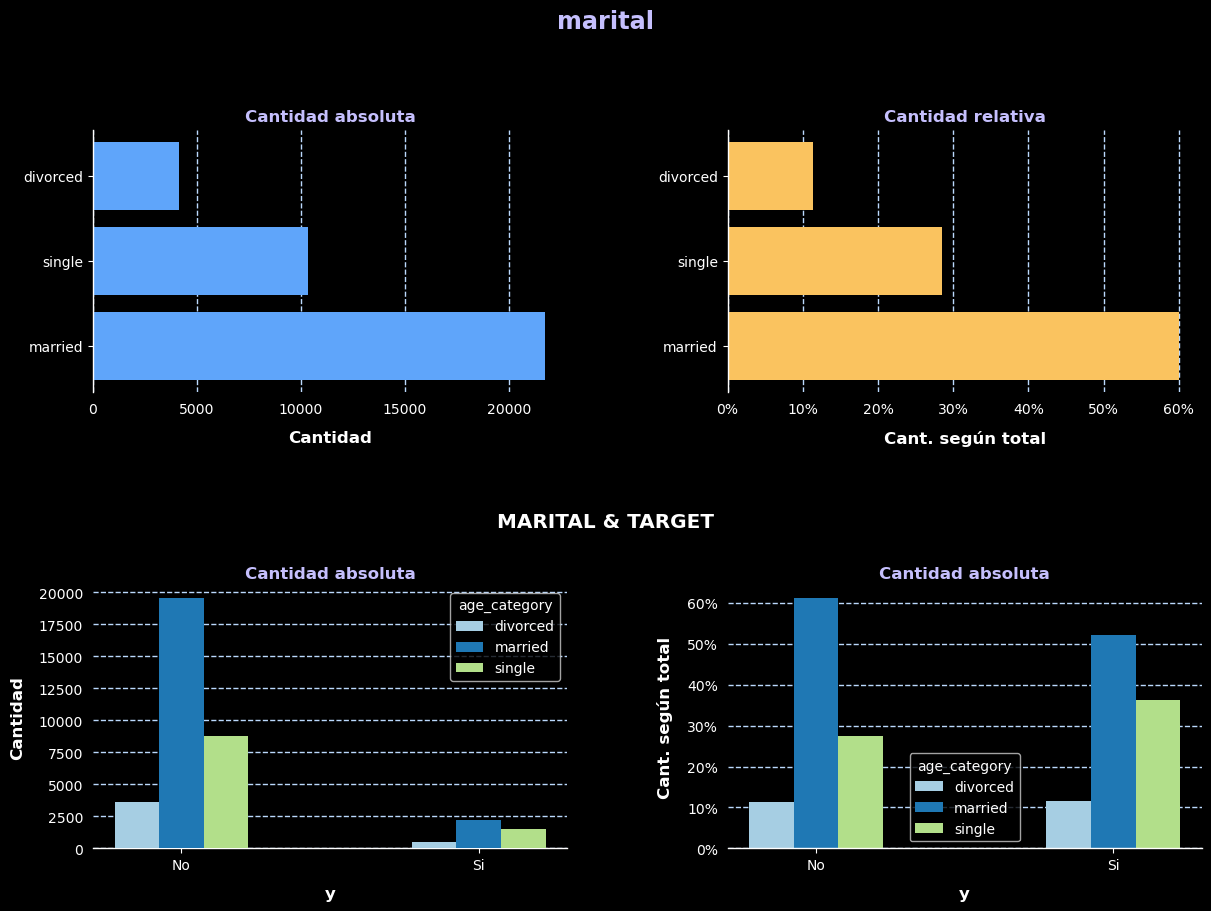

In [252]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("marital",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["marital"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["marital"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("Paired", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "MARITAL & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "marital", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.15
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  data=to_plot,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/1), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="age_category")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "marital", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.15
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  data=to_plot,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/1), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="age_category")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

#### Job vs TARGET

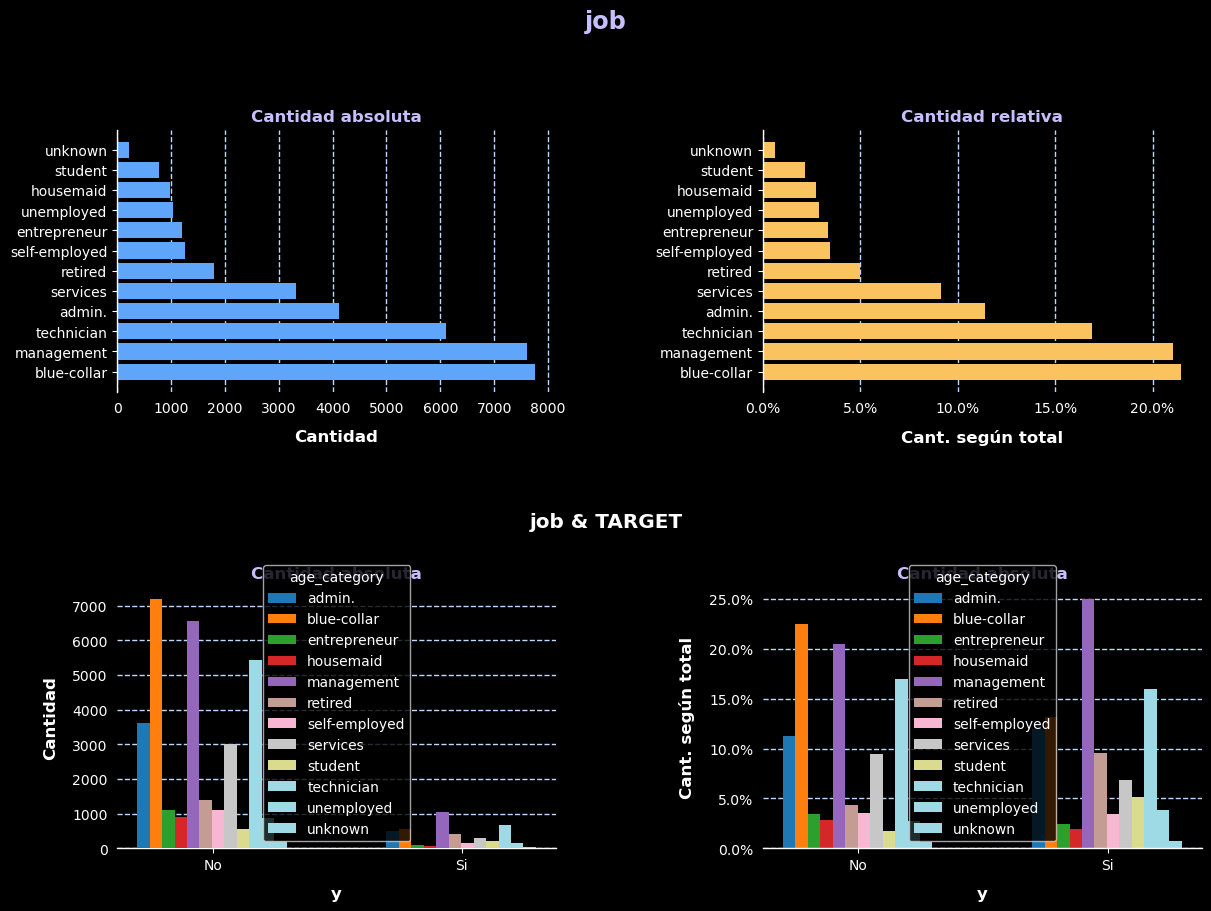

In [375]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("job",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["job"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["job"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("tab20", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "job & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "job", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.05
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/.18), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="age_category")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "job", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.05
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/.18), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="age_category")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

#### Education vs TARGET

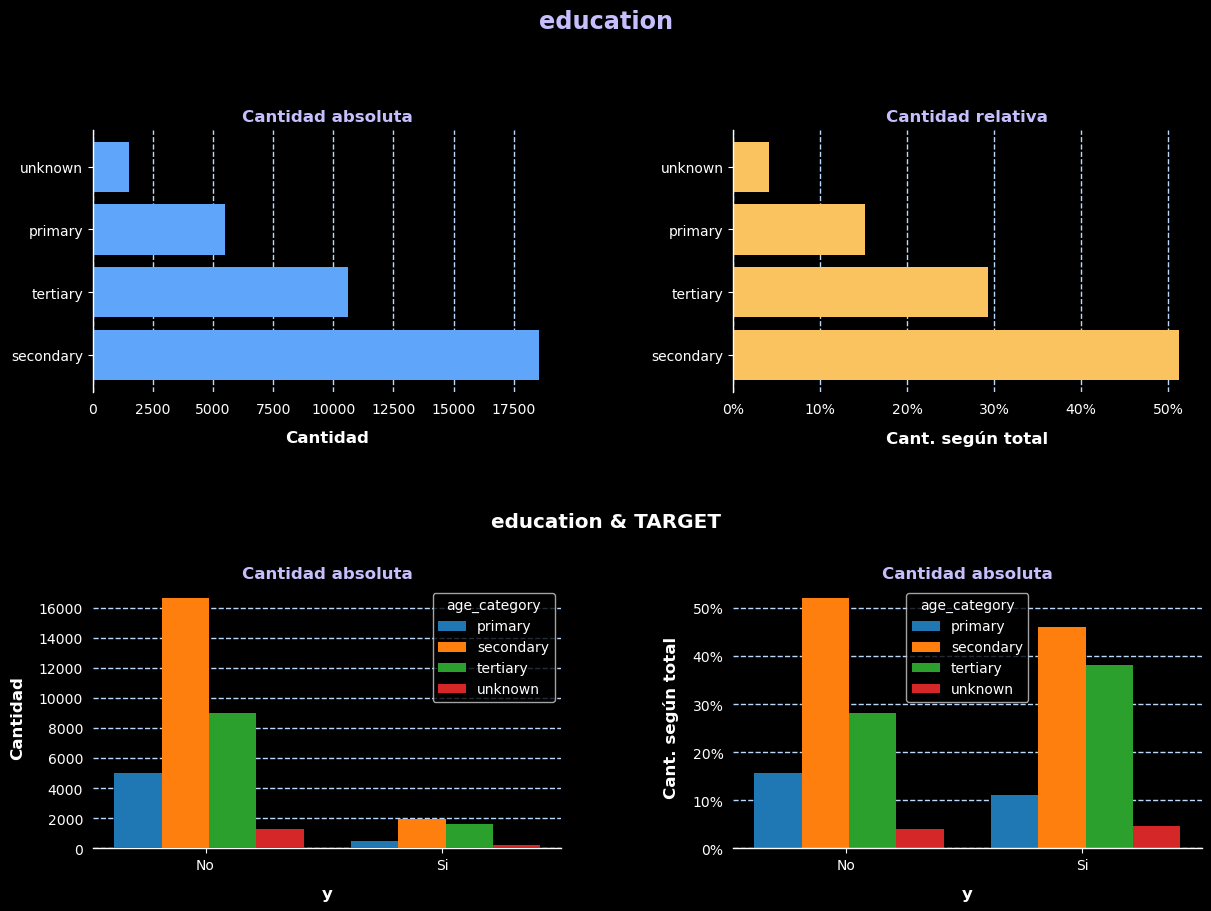

In [360]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("education",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["education"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["education"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("tab20", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "education & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "education", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.2
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/.7), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="age_category")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "education", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.2
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/.7), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="age_category")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

#### Default vs TARGET

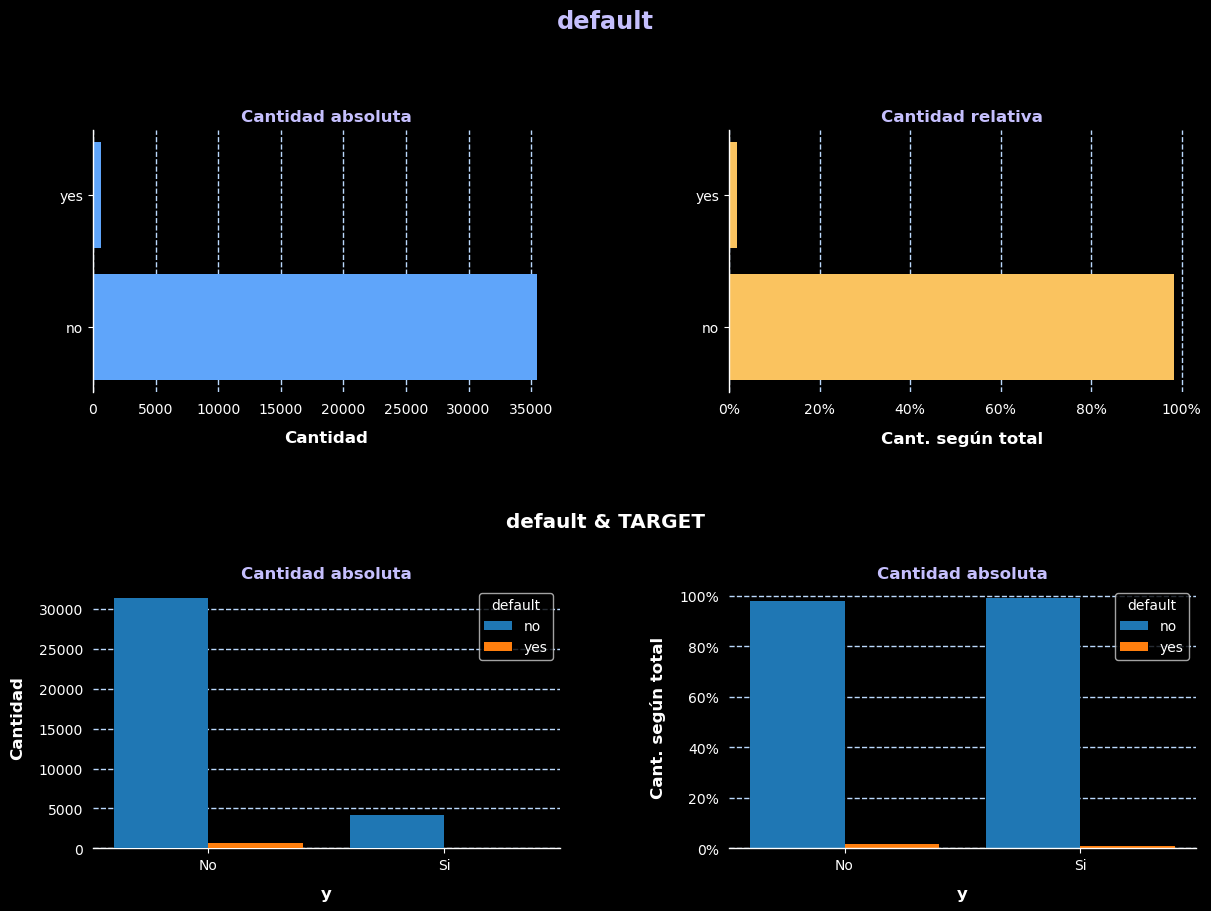

In [359]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("default",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["default"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["default"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("tab20", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "default & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "default", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.4
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/2), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="default")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "default", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.4
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/2), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="default")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

#### Housing VS TARGET

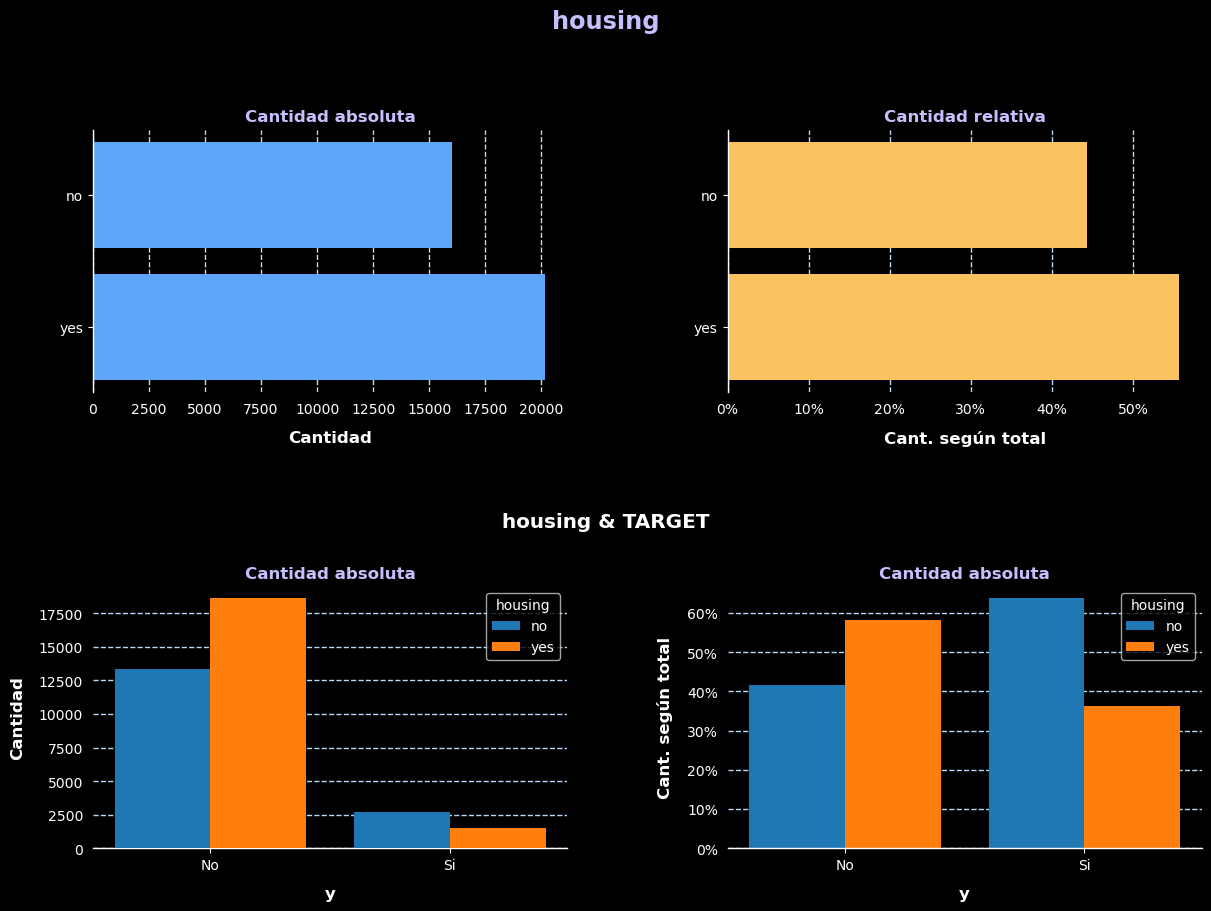

In [358]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("housing",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["housing"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["housing"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("tab20", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "housing & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "housing", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.4
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/2), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="housing")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "housing", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.4
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  facecolor=cmap(index),
						  label=label,
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/2), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="housing")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

#### Loan VS TARGET

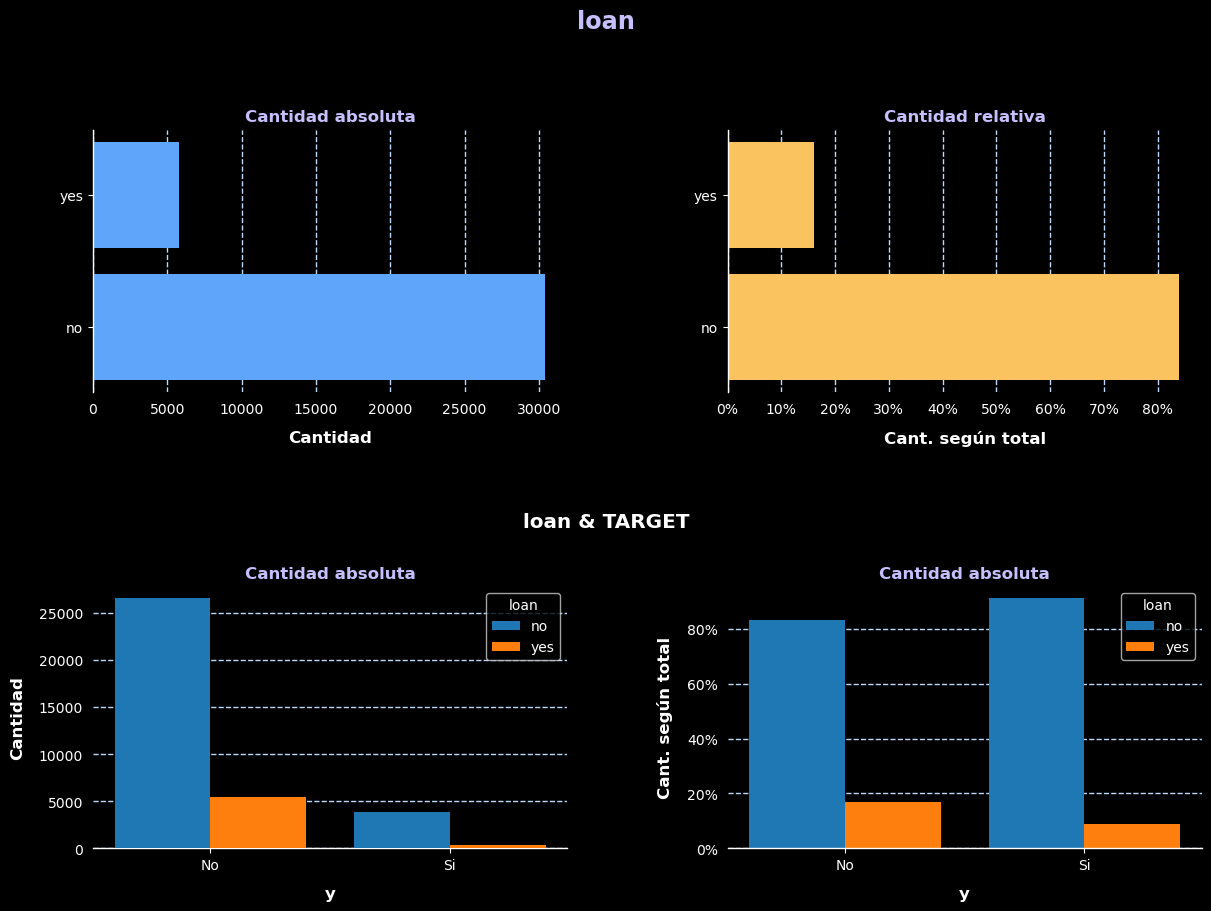

In [376]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("loan",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["loan"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["loan"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("tab20", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "loan & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "loan", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.4
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/2), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="loan")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "loan", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.4
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  facecolor=cmap(index),
						  label=label,
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/2), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="loan")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

#### Contact VS TARGET

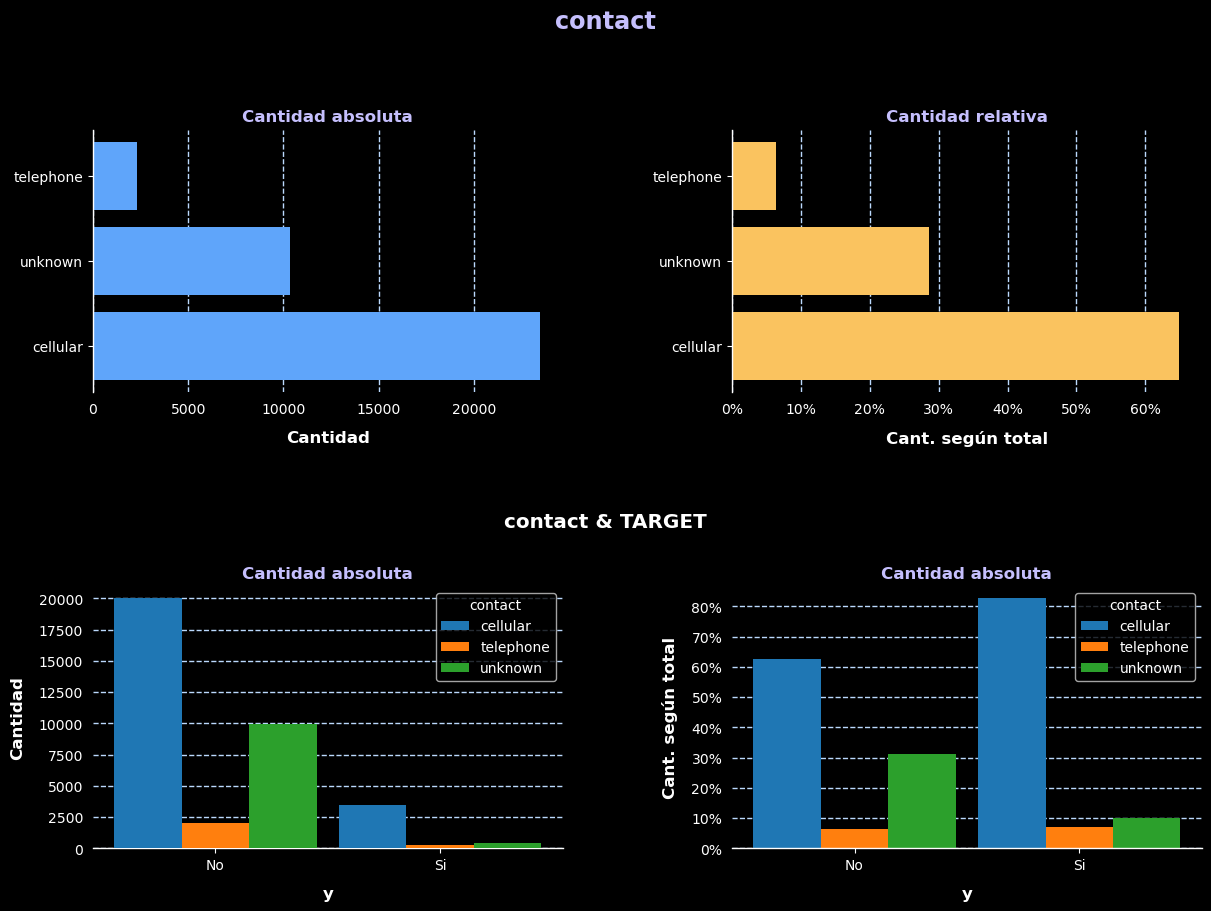

In [382]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("contact",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["contact"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["contact"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("tab20", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "contact & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "contact", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.3
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/1), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="contact")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "contact", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.3
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  facecolor=cmap(index),
						  label=label,
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/1), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="contact")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

#### Poutcome VS TARGET

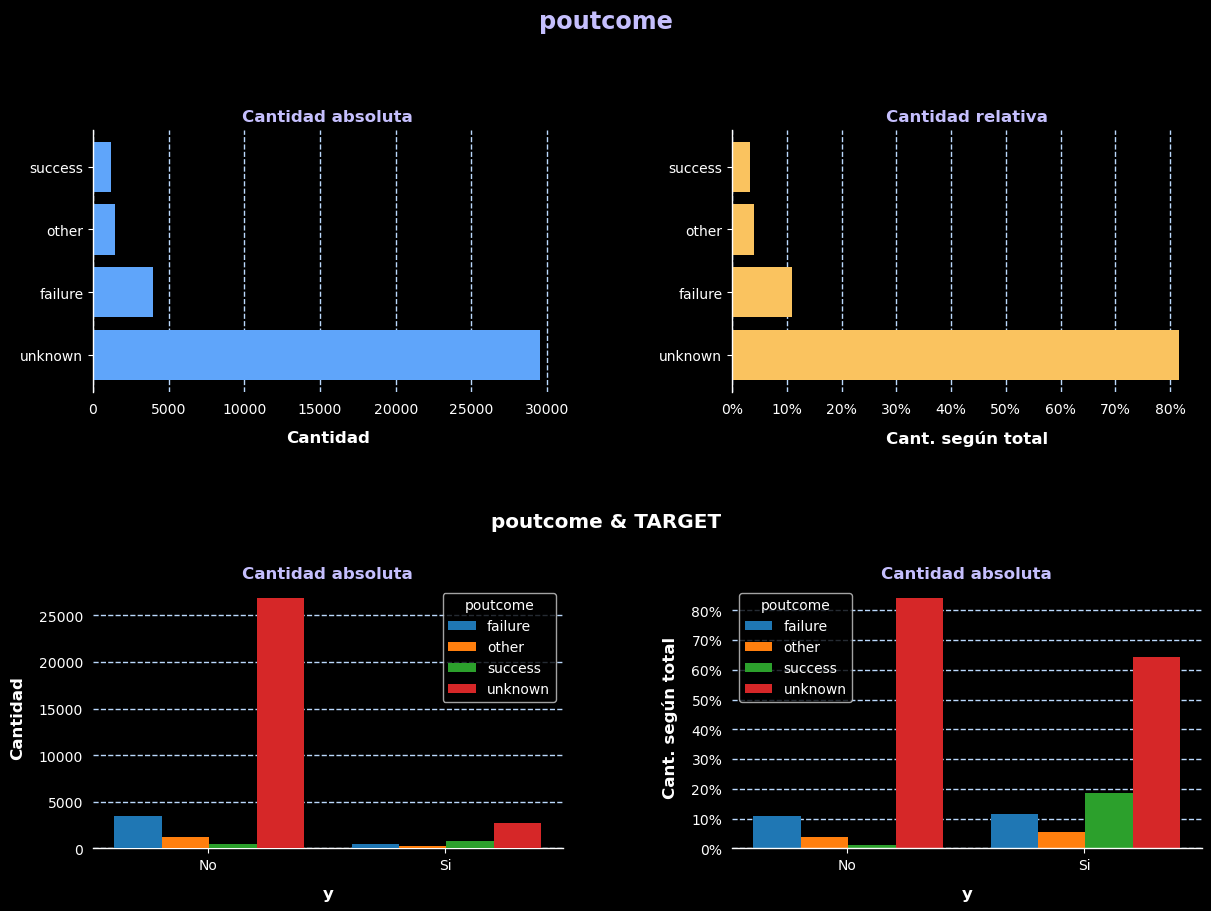

In [395]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle("poutcome",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.12)

##
# CATEGORY
##


############
# CATEGORY #
############
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = df_train["poutcome"].value_counts()
axs[0][0].barh(y=data.index,
			   width=data.values,
			   data=data,
			   color="#5FA5FA",
			   zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].tick_params(axis="x", width=0)
axs[0][0].set_yticks(ticks=data.index)
#axs[0][0].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][0].set_xlabel("Cantidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = df_train["poutcome"].value_counts(normalize=True)
axs[0][1].barh(y=data.index,
			  width=data.values,
			  data=data,
			  color="#FAC35F",
			  zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[0][1].set_xticks(ticks=data.index)
axs[0][1].set_yticks(ticks=data.index)
#axs[0][1].set_xlabel("age_category", labelpad=10, fontdict=font_config)

axs[0][1].set_xlabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[0][1].tick_params(axis="x", width=0)
axs[0][1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["bottom", "top", "right"]].set_visible(False)
axs[0][1].spines["left"].set_linewidth(1)




######################
# CATEGORY VS TARGET #
######################
colors = ["#5F72FA", "#FAAC5F", "#5FD4FA", "#FAD65F", "#6C6E7A", "#7A756C"]
cmap = plt.get_cmap("tab20", lut=10)

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "poutcome & TARGET",
		 va="center",
		 ha="center",
		 fontdict=font_config)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)


data = target_groupby_category("y", "poutcome", df_train, relative=False)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.2
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][0].bar(x=x + offset,
						  height=to_plot.values,
						  label=label,
						  facecolor=cmap(index),
						  width=width,
						  zorder=3)

axs[1][0].tick_params(axis="y", width=0)
axs[1][0].set_xticks(ticks=x + (width/.68), labels=["No", "Si"])

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Cantidad", labelpad=10, fontdict=font_config)

axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend(title="poutcome")





font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = target_groupby_category("y", "poutcome", df_train, relative=True)
target = data.index
categories = data.columns
x = np.arange(len(target))

width = 0.2
for index, label in enumerate(categories):
	offset = width * index
	to_plot = data.loc[:, label]
	rects = axs[1][1].bar(x=x + offset,
						  height=to_plot.values,
						  facecolor=cmap(index),
						  label=label,
						  width=width,
						  zorder=2)

axs[1][1].tick_params(axis="y", width=0)
axs[1][1].set_xticks(ticks=x + (width/0.68), labels=["No", "Si"])


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_xlabel("y", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("Cant. según total", labelpad=10, fontdict=font_config)
axs[1][1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1][1].grid(axis="y",
			   alpha=1,
			   color="#BBD9FD",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)
axs[1][1].legend(title="poutcome")

fig.get_layout_engine().set(hspace=0.3, wspace=0.15)
plt.show()

Conclusión:

La variable `default` parece no tener injerencia en la variable `target`. La variable `pdays` se puede formatear y transformar en una variable que represente contactado y no contactado.

## Transformations

In [475]:
df_train["contacted_before"] = df_train["pdays"].apply(lambda x: x != -1)
df_test["contacted_before"] = df_test["pdays"].apply(lambda x: x != -1)

In [476]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [477]:
features = df_train.columns
features = features.drop("y")
target = "y"

print("Features:", features.values)

Features: ['age' 'job' 'marital' 'education' 'default' 'balance' 'housing' 'loan'
 'contact' 'day' 'month' 'duration' 'campaign' 'pdays' 'previous'
 'poutcome' 'contacted_before']


#### OneHotEncoding

Codificamos las varibles categóricas utilizando `OneHotEncoder`.

In [478]:
data = get_quality(df_train[features])
mask = data["Cardinality"] < 15
data[mask]

Cardinality  Uniqueness  Null
job                      12.0    0.000332   0.0
marital                   3.0    0.000083   0.0
education                 4.0    0.000111   0.0
default                   2.0    0.000055   0.0
housing                   2.0    0.000055   0.0
loan                      2.0    0.000055   0.0
contact                   3.0    0.000083   0.0
month                    12.0    0.000332   0.0
poutcome                  4.0    0.000111   0.0
contacted_before          2.0    0.000055   0.0

In [480]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

category = data[mask].index
categorical = category.drop(labels=["month"])

preprocessing = OneHotEncoder()
transformed = preprocessing.fit_transform(df_train[categorical])
categories = preprocessing.get_feature_names_out()

encoding = pd.DataFrame(transformed.toarray(), columns=categories)
df_train = pd.concat([df_train, encoding], axis=1)
df_train.drop(columns=categorical.values, inplace=True)
df_train.head()

age  balance  day month  duration  campaign  pdays  previous    y  \
0   41      372   11   jul       117         1     -1         0   no   
1   51     4305    4   may       126         1     -1         0   no   
2   30     1058    4   feb       515         1     -1         0   no   
3   75      324   12   nov       124         2     91         4   no   
4   59     9676   27   mar       234         2     -1         0  yes   

   job_admin.  ...  loan_yes  contact_cellular  contact_telephone  \
0         0.0  ...       0.0               0.0                1.0   
1         0.0  ...       0.0               1.0                0.0   
2         0.0  ...       0.0               1.0                0.0   
3         0.0  ...       0.0               0.0                1.0   
4         0.0  ...       0.0               0.0                1.0   

   contact_unknown  poutcome_failure  poutcome_other  poutcome_success  \
0              0.0               0.0             0.0               0.0   
1              0.0               0.0             0.0               0.0   
2              0.0               0.0             0.0               0.0   
3              0.0               0.0             1.0               0.0   
4              0.0               0.0             0.0               0.0   

   poutcome_unknown  contacted_before_False  contacted_before_True  
0               1.0                     1.0                    0.0  
1               1.0                     1.0                    0.0  
2               1.0                     1.0                    0.0  
3               0.0                     0.0                    1.0  
4               1.0                     1.0                    0.0  

[5 rows x 43 columns]

In [481]:
preprocessing = OneHotEncoder()
transformed = preprocessing.fit_transform(df_test[categorical])
categories = preprocessing.get_feature_names_out()

encoding = pd.DataFrame(transformed.toarray(), columns=categories)
df_test = pd.concat([df_test, encoding], axis=1)
df_test.drop(columns=categorical.values, inplace=True)

#### OrdinalEncoder

In [ ]:
print(df_train["month"].unique())
month_ordinal = [
	"jan",
	"feb",
	"mar",
	"apr",
	"may",
	"jun",
	"jul",
	"aug",
	"sep",
	"oct",
	"nov",
	"dec"
]

In [492]:
preprocessing = OrdinalEncoder(categories=[month_ordinal])
preprocessing.fit(df_train[["month"]])
transformed = preprocessing.transform(df_train[["month"]])
columns = preprocessing.get_feature_names_out()

df_train["month"] = pd.Series(transformed[:,0], name="month")
df_train.head()

['jul' 'may' 'feb' 'nov' 'mar' 'aug' 'apr' 'jun' 'jan' 'sep' 'oct' 'dec']


age  balance  day  month  duration  campaign  pdays  previous    y  \
0   41      372   11    6.0       117         1     -1         0   no   
1   51     4305    4    4.0       126         1     -1         0   no   
2   30     1058    4    1.0       515         1     -1         0   no   
3   75      324   12   10.0       124         2     91         4   no   
4   59     9676   27    2.0       234         2     -1         0  yes   

   job_admin.  ...  loan_yes  contact_cellular  contact_telephone  \
0         0.0  ...       0.0               0.0                1.0   
1         0.0  ...       0.0               1.0                0.0   
2         0.0  ...       0.0               1.0                0.0   
3         0.0  ...       0.0               0.0                1.0   
4         0.0  ...       0.0               0.0                1.0   

   contact_unknown  poutcome_failure  poutcome_other  poutcome_success  \
0              0.0               0.0             0.0               0.0   
1              0.0               0.0             0.0               0.0   
2              0.0               0.0             0.0               0.0   
3              0.0               0.0             1.0               0.0   
4              0.0               0.0             0.0               0.0   

   poutcome_unknown  contacted_before_False  contacted_before_True  
0               1.0                     1.0                    0.0  
1               1.0                     1.0                    0.0  
2               1.0                     1.0                    0.0  
3               0.0                     0.0                    1.0  
4               1.0                     1.0                    0.0  

[5 rows x 43 columns]

In [493]:
preprocessing = OrdinalEncoder(categories=[month_ordinal])
preprocessing.fit(df_test[["month"]])
transformed = preprocessing.transform(df_test[["month"]])
columns = preprocessing.get_feature_names_out()

df_test["month"] = pd.Series(transformed[:,0], name="month")

#### Escalado

In [573]:
df_train_scaled = df_train.copy()
df_test_scaled = df_test.copy()

In [574]:
data = get_quality(df_train_scaled)
mask = data["Cardinality"] >= 12
data[mask]

Cardinality  Uniqueness  Null
age              76.0    0.002101   0.0
balance        6608.0    0.182703   0.0
day              31.0    0.000857   0.0
month            12.0    0.000332   0.0
duration       1495.0    0.041335   0.0
campaign         48.0    0.001327   0.0
pdays           523.0    0.014460   0.0
previous         40.0    0.001106   0.0

In [575]:
from sklearn.preprocessing import StandardScaler

numeric = data[mask].index
numerical = numeric.drop(labels=["month"])

standard_scaler = StandardScaler()
standard_scaler.set_output(transform="pandas")
transformed = standard_scaler.fit_transform(
		df_train_scaled.loc[:, numerical])
columns = standard_scaler.get_feature_names_out()

df_train_scaled.loc[:, numerical] = transformed
df_train_scaled.head()

/tmp/ipykernel_9735/2062075141.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.00951276  0.95084677 -1.02595464 ...  0.85671337  0.48017976
  1.32738037]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_scaled.loc[:, numerical] = transformed
/tmp/ipykernel_9735/2062075141.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.32286727  0.95082    -0.10070875 ... -0.2950165  -0.39702806
 -0.56478042]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_train_scaled.loc[:, numerical] = transformed
/tmp/ipykernel_9735/2062075141.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.57850123 -1.42010505 -1.42010505 ... -1.54033416 -1.0594177
  1.70585197]' has dtype incompati

age   balance       day  month  duration  campaign     pdays  \
0  0.009513 -0.322867 -0.578501    6.0 -0.550034 -0.566224 -0.411711   
1  0.950847  0.950820 -1.420105    4.0 -0.515177 -0.566224 -0.411711   
2 -1.025955 -0.100709 -1.420105    1.0  0.991441 -0.566224 -0.411711   
3  3.210048 -0.338412 -0.458272   10.0 -0.522923 -0.244497  0.506422   
4  1.703914  2.690198  1.345165    2.0 -0.096887 -0.244497 -0.411711   

   previous    y  job_admin.  ...  loan_yes  contact_cellular  \
0 -0.242944   no         0.0  ...       0.0               0.0   
1 -0.242944   no         0.0  ...       0.0               1.0   
2 -0.242944   no         0.0  ...       0.0               1.0   
3  1.432170   no         0.0  ...       0.0               0.0   
4 -0.242944  yes         0.0  ...       0.0               0.0   

   contact_telephone  contact_unknown  poutcome_failure  poutcome_other  \
0                1.0              0.0               0.0             0.0   
1                0.0              0.0               0.0             0.0   
2                0.0              0.0               0.0             0.0   
3                1.0              0.0               0.0             1.0   
4                1.0              0.0               0.0             0.0   

   poutcome_success  poutcome_unknown  contacted_before_False  \
0               0.0               1.0                     1.0   
1               0.0               1.0                     1.0   
2               0.0               1.0                     1.0   
3               0.0               0.0                     0.0   
4               0.0               1.0                     1.0   

   contacted_before_True  
0                    0.0  
1                    0.0  
2                    0.0  
3                    1.0  
4                    0.0  

[5 rows x 43 columns]

In [576]:
standard_scaler = StandardScaler()
standard_scaler.set_output(transform="pandas")
transformed = standard_scaler.fit_transform(
		df_test_scaled.loc[:, numerical])
columns = standard_scaler.get_feature_names_out()

df_test_scaled.loc[:, numerical] = transformed

/tmp/ipykernel_9735/3713420812.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.29108945 -0.57413481 -0.10239254 ...  3.10545491 -1.14022554
  0.08630437]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test_scaled.loc[:, numerical] = transformed
/tmp/ipykernel_9735/3713420812.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.33308582  0.00821672 -0.24130405 ...  1.46695355 -0.52432692
 -0.46604724]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_test_scaled.loc[:, numerical] = transformed
/tmp/ipykernel_9735/3713420812.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.58408764  0.14559147  0.02571678 ... -1.53265407 -1.41277939
  0.50521551]' has dtype incompatible 

<Axes: >

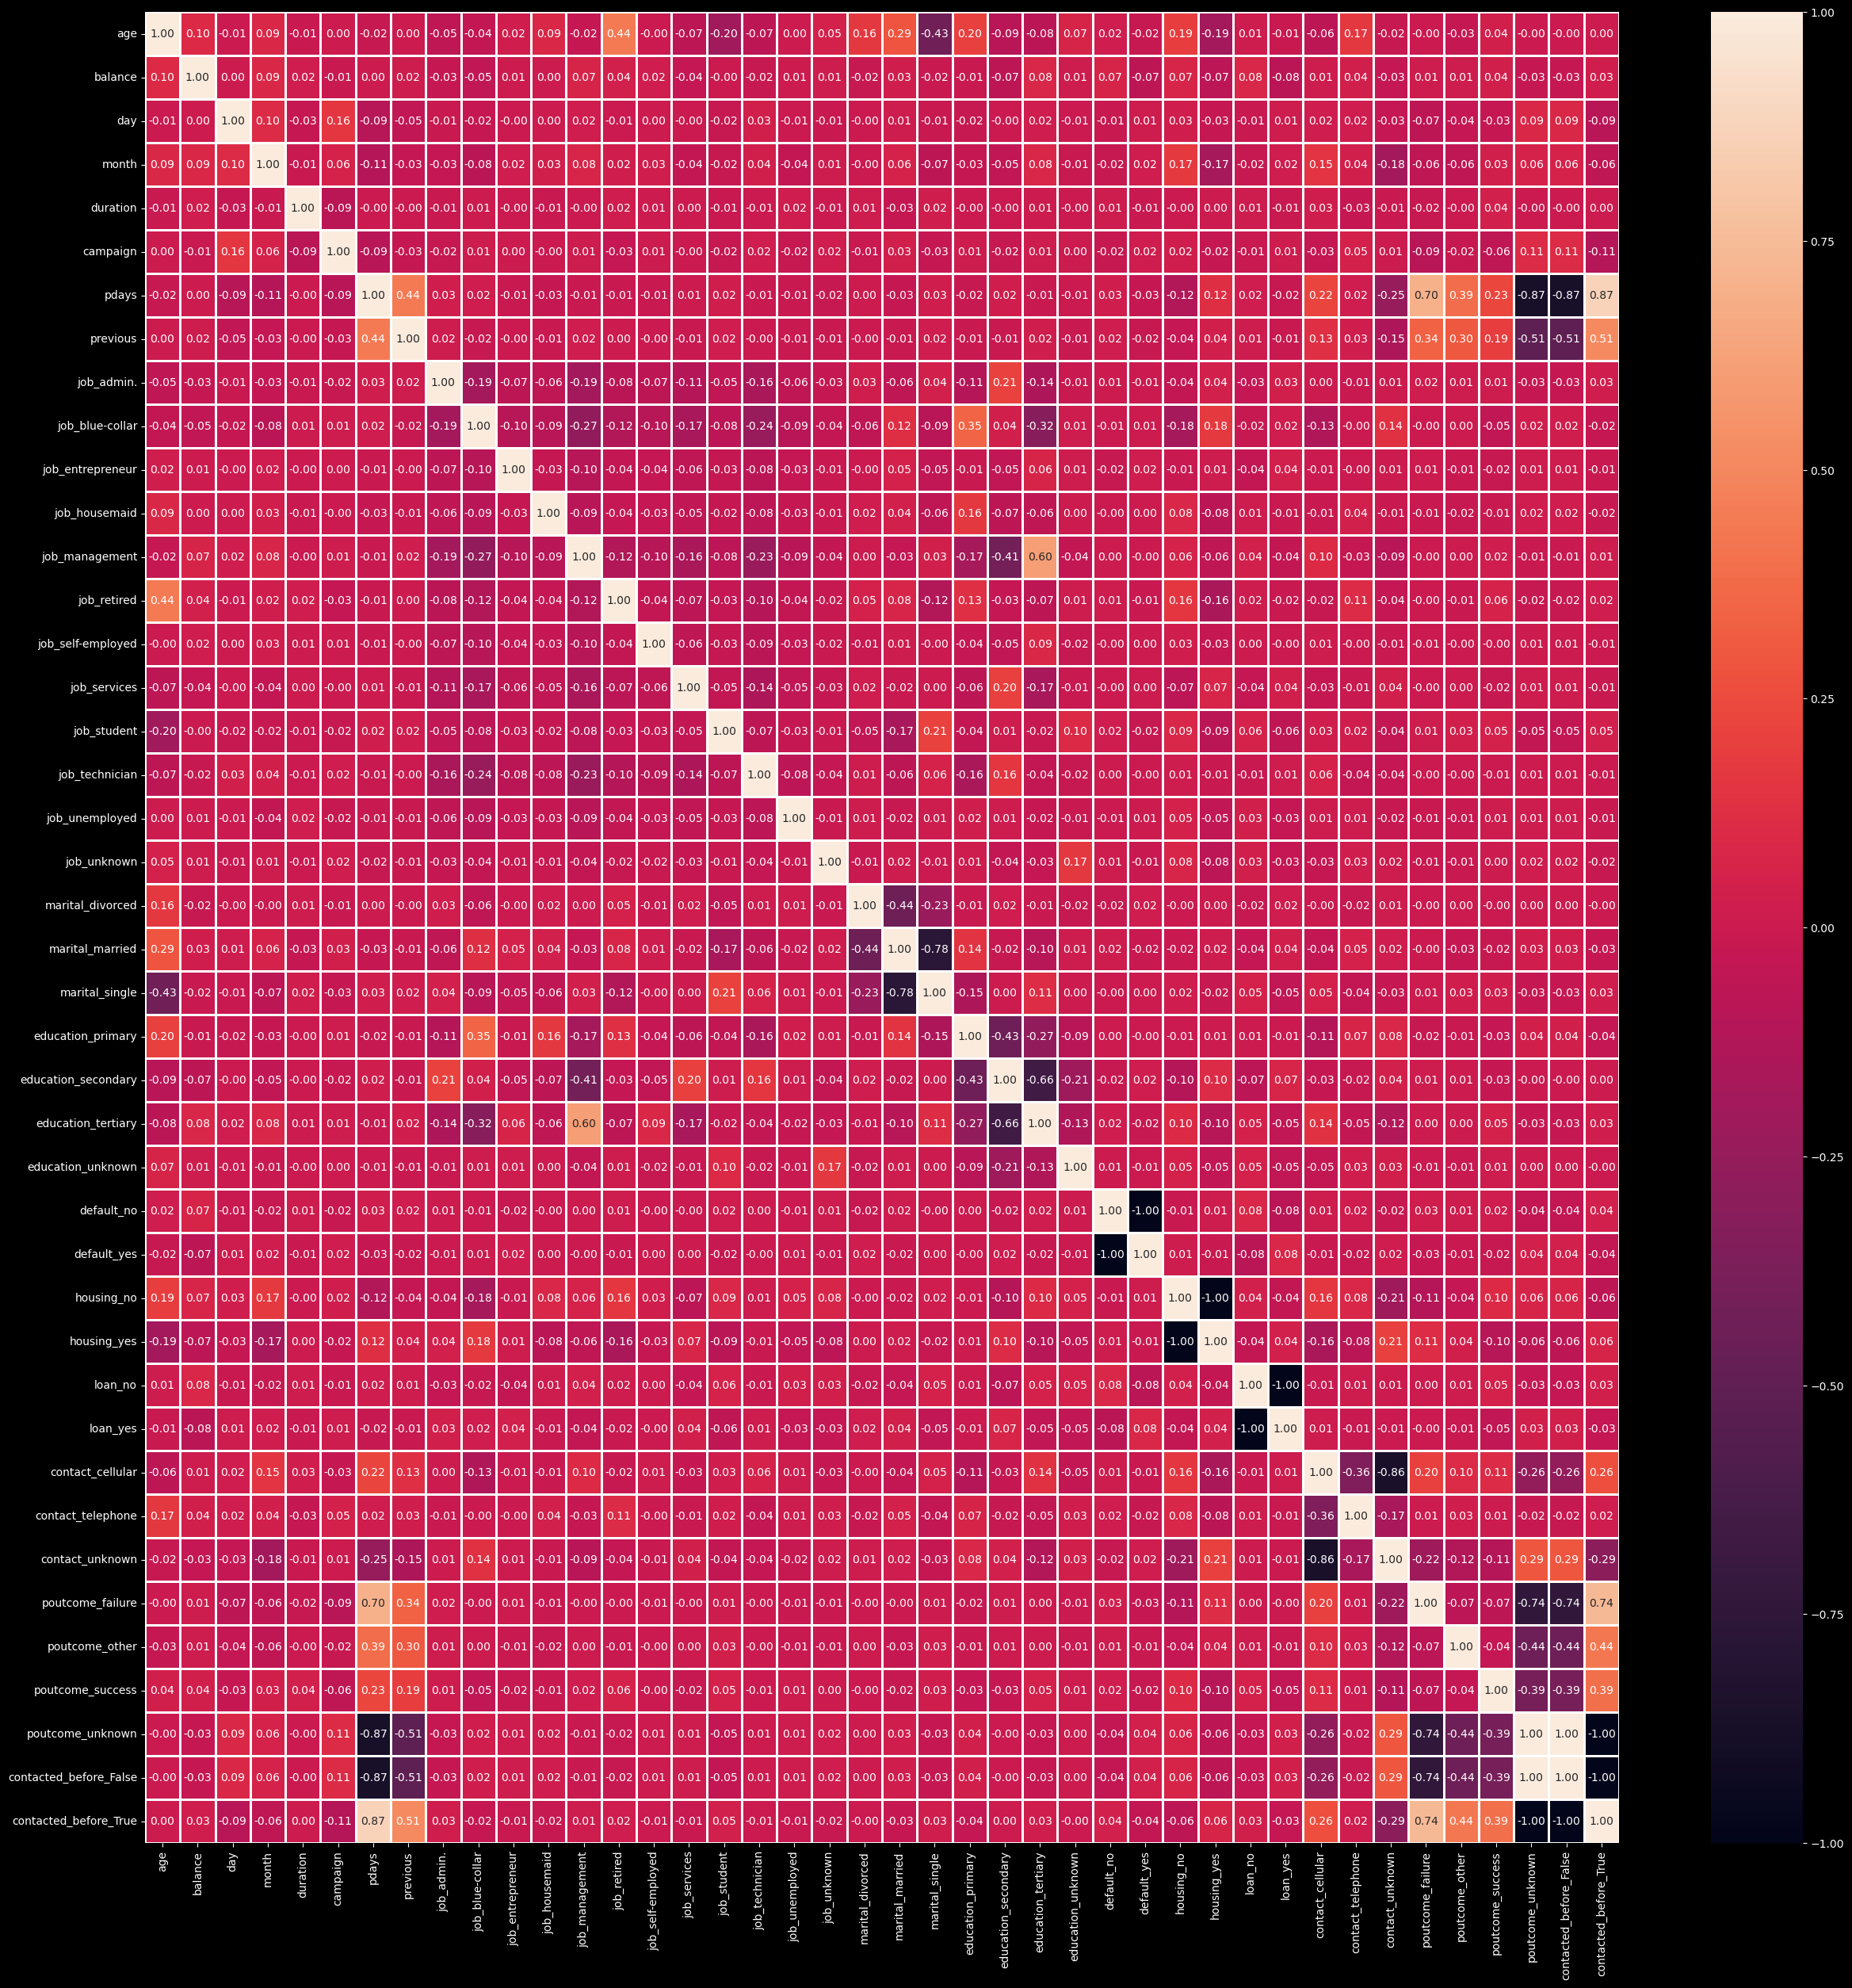

In [701]:
import seaborn as sns


fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(df_train[features].corr(),
			annot=True,
			fmt=".2f", 
			linewidths=1,
			square=False,
			ax=ax)

## Base Model: `LinearRegression`

In [630]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression


scaled_features = df_train_scaled.columns
scaled_features = scaled_features.drop(labels="y")

logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(df_train_scaled[scaled_features], df_train_scaled["y"])
predicts = logistic_regression.predict(df_train_scaled[scaled_features])

print("Train Report".upper())
print("="*55)
print(classification_report(df_train_scaled["y"], predicts))

TRAIN REPORT
              precision    recall  f1-score   support

          no       0.92      0.98      0.95     31937
         yes       0.65      0.33      0.43      4231

    accuracy                           0.90     36168
   macro avg       0.78      0.65      0.69     36168
weighted avg       0.88      0.90      0.89     36168



In [629]:
print("Test Report".upper())
print("="*55)
predicts = logistic_regression.predict(df_test_scaled[scaled_features])
print(classification_report(df_test_scaled["y"], predicts))

TEST REPORT
              precision    recall  f1-score   support

          no       0.91      0.98      0.95      7985
         yes       0.65      0.31      0.42      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.64      0.68      9043
weighted avg       0.88      0.90      0.88      9043



Por lo pronto podemos entender que nuestro modelo no tiene un buen rendimiento, principalmente, la clase que se encuentra desbalanceada `yes`, es la que más sufre en el `recall`.

Ya que tenemos un dataset muy desbalanceado, utilizamos la métrica `balanced_accuracy` para evaluar nuestros resultados.

In [631]:
from sklearn.model_selection import StratifiedKFold, cross_validate

stratified_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
results = cross_validate(estimator=logistic_regression,
						 X=df_train_scaled[scaled_features],
						 y=df_train_scaled["y"],
						 cv=stratified_folds,
						 scoring="balanced_accuracy",
						 return_train_score=True,
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_score"] * 100):.3f}")
print(f"TEST Balanced Accuracy: {np.mean(results["test_score"] * 100):.3f}")

TRAIN Balanced Accuracy: 65.166
TEST Balanced Accuracy: 65.101


#### Features Importance

Analizamos nuestras `features` para determinar el peso de cada una en nuestro modelo.

In [637]:
intercept = logistic_regression.intercept_
print("Ordenada al origen:", intercept)

coeficientes = logistic_regression.coef_.ravel()
coeficientes = pd.Series(data=coeficientes,
						 index=df_train[scaled_features].columns,
						 name="coeficientes")
coef = pd.DataFrame(coeficientes, index=df_train[scaled_features].columns)
coef

Ordenada al origen: [-0.57579994]


coeficientes
age                         0.027070
balance                     0.048729
day                        -0.027460
month                      -0.014067
duration                    1.050270
campaign                   -0.357964
pdays                       0.006072
previous                    0.017318
job_admin.                  0.140135
job_blue-collar            -0.232624
job_entrepreneur           -0.300824
job_housemaid              -0.472587
job_management             -0.091732
job_retired                 0.479568
job_self-employed          -0.237452
job_services               -0.167569
job_student                 0.646226
job_technician             -0.128984
job_unemployed             -0.111875
job_unknown                -0.081363
marital_divorced           -0.225546
marital_married            -0.312071
marital_single             -0.021465
education_primary          -0.364075
education_secondary        -0.167051
education_tertiary          0.090808
education_unknown          -0.118764
default_no                 -0.203409
default_yes                -0.355673
housing_no                  0.110663
housing_yes                -0.669745
loan_no                     0.005090
loan_yes                   -0.564172
contact_cellular            0.220698
contact_telephone           0.152023
contact_unknown            -0.931804
poutcome_failure           -0.843148
poutcome_other             -0.624537
poutcome_success            1.444464
poutcome_unknown           -0.535860
contacted_before_False     -0.562276
contacted_before_True       0.003194

Las variables con menos peso en el modelo...

In [649]:
coef.query("coeficientes < 0.2 and coeficientes > -0.2")

coeficientes
age                        0.027070
balance                    0.048729
day                       -0.027460
month                     -0.014067
pdays                      0.006072
previous                   0.017318
job_admin.                 0.140135
job_management            -0.091732
job_services              -0.167569
job_technician            -0.128984
job_unemployed            -0.111875
job_unknown               -0.081363
marital_single            -0.021465
education_secondary       -0.167051
education_tertiary         0.090808
education_unknown         -0.118764
housing_no                 0.110663
loan_no                    0.005090
contact_telephone          0.152023
contacted_before_True      0.003194

Como podemos observar, algunas de nuestras variables no tienen tanta relevancia en nuestro modelo. 

**Conclusión**:

Nuestro baseline es bastante pobre. Tiene problemas con el desbalanceo de nuestra clase target `y`, por lo que no logra resolver correctamente en estas instancias.

## `DecisionTreeClassifier`

In [744]:
features = df_train.columns
features = features.drop(labels=["pdays", "default_yes", "default_no", "y"])
print(features.values)

['age' 'balance' 'day' 'month' 'duration' 'campaign' 'previous'
 'job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'job_unknown'
 'marital_divorced' 'marital_married' 'marital_single' 'education_primary'
 'education_secondary' 'education_tertiary' 'education_unknown'
 'housing_no' 'housing_yes' 'loan_no' 'loan_yes' 'contact_cellular'
 'contact_telephone' 'contact_unknown' 'poutcome_failure' 'poutcome_other'
 'poutcome_success' 'poutcome_unknown' 'contacted_before_False'
 'contacted_before_True']


In [746]:
from sklearn.tree import DecisionTreeClassifier


decision_tree = DecisionTreeClassifier(max_depth=10, random_state=99)
decision_tree.fit(df_train[features], df_train["y"])
decision_tree

DecisionTreeClassifier(max_depth=10, random_state=99)

In [747]:
predicts = decision_tree.predict(df_train[features])

print("Train Report".upper())
print("="*55)
print(classification_report(df_train["y"], predicts))

TRAIN REPORT
              precision    recall  f1-score   support

          no       0.94      0.97      0.96     31937
         yes       0.75      0.57      0.64      4231

    accuracy                           0.93     36168
   macro avg       0.85      0.77      0.80     36168
weighted avg       0.92      0.93      0.92     36168



In [748]:
predicts = decision_tree.predict(df_test[features])

print("Test Report".upper())
print("="*55)
print(classification_report(df_test["y"], predicts))

TEST REPORT
              precision    recall  f1-score   support

          no       0.92      0.96      0.94      7985
         yes       0.57      0.41      0.48      1058

    accuracy                           0.90      9043
   macro avg       0.75      0.68      0.71      9043
weighted avg       0.88      0.90      0.89      9043



In [749]:
stratified_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
results = cross_validate(estimator=decision_tree,
						 X=df_train[features],
						 y=df_train["y"],
						 cv=stratified_folds,
						 scoring="balanced_accuracy",
						 return_train_score=True,
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_score"] * 100):.3f}")
print(f"TEST Balanced Accuracy: {np.mean(results["test_score"] * 100):.3f}")

TRAIN Balanced Accuracy: 77.751
TEST Balanced Accuracy: 70.266


Podemos verificar que en nuestro `DecisionTreeClassifier`, nuestro modelo tiene una mejor performance en nuestro set de `test`. Nuestro `balanced_accuracy` es de 70% en comparación al 65% en nuestro baseline.


#### `Feature Importance`

In [750]:
feature_importances = decision_tree.feature_importances_
coef = pd.Series(data=feature_importances,
				 index=features,
				 name="coeficientes")
mask = (coef < 0.1) & (coef > -0.1)
coef.loc[mask].index

Index(['age', 'balance', 'day', 'month', 'campaign', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_unknown',
       'contacted_before_False', 'contacted_before_True'],
      dtype='object')

#### `GridSearch`

Realizamos un `GridSearchCV` para buscar los mejores parámetros para nuestro modelo.

In [751]:
from sklearn.model_selection import GridSearchCV


decision_tree = DecisionTreeClassifier(random_state=99)

grid = {
    "criterion": ["gini", "entropy"],
	"class_weight": ["balanced", None],
	"max_depth": range(5, 15, 2),
	"max_features": ["sqrt", "log2", None],
	"min_samples_leaf": range(5, 50, 5),
	"min_samples_split": range(5, 30, 5)
}

stratified_folds = StratifiedKFold(n_splits=10,
								   shuffle=True,
								   random_state=99)
grid_search = GridSearchCV(decision_tree,
						   param_grid=grid,
						   cv=stratified_folds,
						   scoring="balanced_accuracy",
						   n_jobs=-1)

grid_search.fit(df_train[features], df_train["y"])

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=99, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=99),
             param_grid={'class_weight': ['balanced', None],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': range(5, 15, 2),
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': range(5, 50, 5),
                         'min_samples_split': range(5, 30, 5)},
             scoring='balanced_accuracy')

In [752]:
grid_search.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 13,
 'max_features': None,
 'min_samples_leaf': 35,
 'min_samples_split': 5}

In [790]:
decision_tree = DecisionTreeClassifier(class_weight="balanced",
									   min_samples_leaf=35,
									   min_samples_split=5,
									   max_depth=13,
									   random_state=99)
decision_tree.fit(df_train[features], df_train["y"])
decision_tree

DecisionTreeClassifier(class_weight='balanced', max_depth=13,
                       min_samples_leaf=35, min_samples_split=5,
                       random_state=99)

In [791]:
predicts = decision_tree.predict(df_train[features])

print("Train Report".upper())
print("="*55)
print(classification_report(df_train["y"], predicts))

TRAIN REPORT
              precision    recall  f1-score   support

          no       0.99      0.83      0.90     31937
         yes       0.42      0.91      0.57      4231

    accuracy                           0.84     36168
   macro avg       0.70      0.87      0.74     36168
weighted avg       0.92      0.84      0.86     36168



In [792]:
stratified_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
results = cross_validate(estimator=decision_tree,
						 X=df_train[features],
						 y=df_train["y"],
						 cv=stratified_folds,
						 scoring="balanced_accuracy",
						 return_train_score=True,
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_score"] * 100):.3f}")
print(f"TEST Balanced Accuracy: {np.mean(results["test_score"] * 100):.3f}")

TRAIN Balanced Accuracy: 87.282
TEST Balanced Accuracy: 83.737


A través del `GridSearchCV`, nuestro modelo obtuvo una mejora sustancial en nuestro set de entrenamiento... Vamos a ver si generaliza correctamente.

In [793]:
predicts = decision_tree.predict(df_test[features])

print("Test Report".upper())
print("="*55)
print(classification_report(df_test["y"], predicts))

TEST REPORT
              precision    recall  f1-score   support

          no       0.98      0.83      0.90      7985
         yes       0.39      0.84      0.54      1058

    accuracy                           0.83      9043
   macro avg       0.68      0.84      0.72      9043
weighted avg       0.91      0.83      0.85      9043



In [794]:
stratified_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
results = cross_validate(estimator=decision_tree,
						 X=df_test[features],
						 y=df_test["y"],
						 cv=stratified_folds,
						 scoring="balanced_accuracy",
						 return_train_score=True,
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_score"] * 100):.3f}")
print(f"TEST Balanced Accuracy: {np.mean(results["test_score"] * 100):.3f}")

TRAIN Balanced Accuracy: 85.968
TEST Balanced Accuracy: 81.756


Al parecer, generaliza correctamente. Seguimos verificando que hay muchas features que no tienen impacto en el modelo. Las podríamos eliminar del mismo...

In [813]:
feature_importances = decision_tree.feature_importances_
coef = pd.Series(data=feature_importances,
				 index=features,
				 name="coeficientes")
print("Original:\n", coef.index)

mask = (coef > 0.1) | (coef < -0.1)
print("Filtradas:\n", coef[mask].index)

Original:
 Index(['age', 'balance', 'day', 'month', 'duration', 'campaign', 'previous',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'housing_no', 'housing_yes', 'loan_no', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'contact_unknown',
       'poutcome_failure', 'poutcome_other', 'poutcome_success',
       'poutcome_unknown', 'contacted_before_False', 'contacted_before_True'],
      dtype='object')
Filtradas:
 Index(['month', 'duration', 'poutcome_success'], dtype='object')


In [814]:
best_features = coef.loc[mask].index

decision_tree = DecisionTreeClassifier(class_weight="balanced",
									   min_samples_leaf=35,
									   min_samples_split=5,
									   max_depth=13,
									   random_state=99)
decision_tree.fit(df_train[best_features], df_train["y"])
decision_tree

DecisionTreeClassifier(class_weight='balanced', max_depth=13,
                       min_samples_leaf=35, min_samples_split=5,
                       random_state=99)

In [815]:
stratified_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
results = cross_validate(estimator=decision_tree,
						 X=df_train[best_features],
						 y=df_train["y"],
						 cv=stratified_folds,
						 scoring="balanced_accuracy",
						 return_train_score=True,
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_score"] * 100):.3f}")
print(f"TEST Balanced Accuracy: {np.mean(results["test_score"] * 100):.3f}")

TRAIN Balanced Accuracy: 82.722
TEST Balanced Accuracy: 79.772


In [816]:
stratified_folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=99)
results = cross_validate(estimator=decision_tree,
						 X=df_test[best_features],
						 y=df_test["y"],
						 cv=stratified_folds,
						 scoring="balanced_accuracy",
						 return_train_score=True,
						 n_jobs=-1)

print(f"TRAIN Balanced Accuracy: {np.mean(results["train_score"] * 100):.3f}")
print(f"TEST Balanced Accuracy: {np.mean(results["test_score"] * 100):.3f}")

TRAIN Balanced Accuracy: 81.636
TEST Balanced Accuracy: 77.818


Nuestro modelo, únicamente con tres features: `month`, `duration` y `poutcome_success` consigue un `balanced_accuracy` de 81.6% en el set de entrenamiento y 77.8% en el set de test... Nada despreciable, si tomamos en cuenta que se encuentra muy próximo en rendimiento al modelo entrenado con 40 features.